# Mezcla de expertos utilizando redes neuronales convolucionales

En este cuaderno se llevara a cabo la implementacion de tecnina de computacion condicional de mezcla de expertos para redes neuronales convolucionales, donde se utilizaran 3 expertos y se escogeran los 2 mejores para concatenar sus 'feature maps' con el fin de lograr una mayor generalizacion al obtener informacion de distintos modelos.

In [1]:
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os 
import copy
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model

# Importar dataset

#parametros por defecto
batch_size = 32
epochs = 100
img_size = (128,128)

print('LOADING TRAIN IMAGES:\n')
train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory = '../input/acrimaDataset',
    # labels = 'inferred', #Los labels son generados tomando en cuenta la estructura del directorio
    # label_mode = 'binary', #Los labels los entregara de la forma = [[1], [0], [1],...] para una loss binary_crossentropy
    # class_names = ['glaucoma', 'normal'], #Solo valido cuando se tiene inferred. lista de nombre de las clases
    color_mode = 'rgb', #Default 'rgb' convertira las imagenes en 1, 3 o 4 canales (grayscale, rgb, rgba)
    batch_size = batch_size, # Default 32. None entrega el dataset con muestras individuales
    image_size = img_size, #Default (256,256). redimensiona las imagenes despues de leerlas en disco. (altura, ancho)
    shuffle = True, #Default True. mezcla la data aleatoriamente
    seed = 42, #optional. establecer semilla para mezclar y aplicar transformaciones
    validation_split = 0.3, #optional. flotante entre 0 y 1 para reservar parte de la data para validacion
    subset = 'training', #subconjunto de la data que retorna. 'training', 'validation', 'both'(retorna tupla con 2 datasets).
    interpolation = 'bilinear', # Default bilinear. metodo para aplicar resize("bilinear", "nearest", "bicubic", "area", "lanczos3", "lanczos5", "gaussian", "mitchellcubic")
    )
print('\n')
print('LOADING VALIDATION-TEST IMAGES:\n')
val_test_dataset = keras.preprocessing.image_dataset_from_directory(
    directory='../input/acrimaDataset',
    # labels="inferred",
    # label_mode="binary",
    # class_names=['glaucoma', 'normal'],
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="validation",
    interpolation = 'bilinear'
)
print('\n')

# Dividir la validacion y prueba del 30% restante

print('SPLITING INTO VALIDATION AND TEST\n')

# Cargar el 10% para validación (1/3 del 30% restante)
valid_dataset_size = int(len(val_test_dataset) * (1/3))
valid_dataset = val_test_dataset.take(valid_dataset_size)

# Cargar el 20% para test (2/3 del 30% restante)
test_dataset = val_test_dataset.skip(valid_dataset_size)

#Contar
i = 0

for im, lb in valid_dataset:
  i += im.shape[0]
#output validacion
print('Found 211 files belonging to 2 classes.')
print(f'Using {i} files for validation.\n\n')

#Contar
i = 0

for im, lb in test_dataset:
  i += im.shape[0]
#output validacion
print('Found 211 files belonging to 2 classes.')
print(f'Using {i} files for test.')

LOADING TRAIN IMAGES:

Found 705 files belonging to 2 classes.
Using 494 files for training.


LOADING VALIDATION-TEST IMAGES:

Found 705 files belonging to 2 classes.
Using 211 files for validation.


SPLITING INTO VALIDATION AND TEST

Found 211 files belonging to 2 classes.
Using 64 files for validation.


Found 211 files belonging to 2 classes.
Using 147 files for test.


# Enfoque Hold Out
## 705[imagenes] -> 100%
<hr>

### entrenamiento: 494[imagenes] -> 70%
### validacion: 64[imagenes] -> 10%
### test: 147[imagenes] -> 20%

# Normalizar imagenes

In [12]:
normalization_layer = keras.layers.Rescaling(1./255)

#Train_dataset
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
#Valid_dataset
valid_dataset = valid_dataset.map(lambda x, y: (normalization_layer(x), y))
#Test_dataset
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

In [2]:
x_train = []
y_train = []

x_valid = []
y_valid = []

x_test = []
y_test = []


for im_b, lb_b in train_dataset:
    x_train.append(im_b.numpy())
    y_train.append(lb_b.numpy())

for im_b, lb_b in valid_dataset:
    x_valid.append(im_b.numpy())
    y_valid.append(lb_b.numpy())
    
for im_b, lb_b in test_dataset:
    x_test.append(im_b.numpy())
    y_test.append(lb_b.numpy())

# Mostrar imagenes

In [14]:
def show_images(dataset):
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):
        for i in range(32):
            ax = plt.subplot(5, 7, i + 1)
            plt.imshow(images[i].numpy())
            if labels[i] == 0:
                plt.title("Glaucoma")
            elif labels[i] == 1:
                plt.title("Normal")
            plt.axis("off")
    plt.show()

## Train

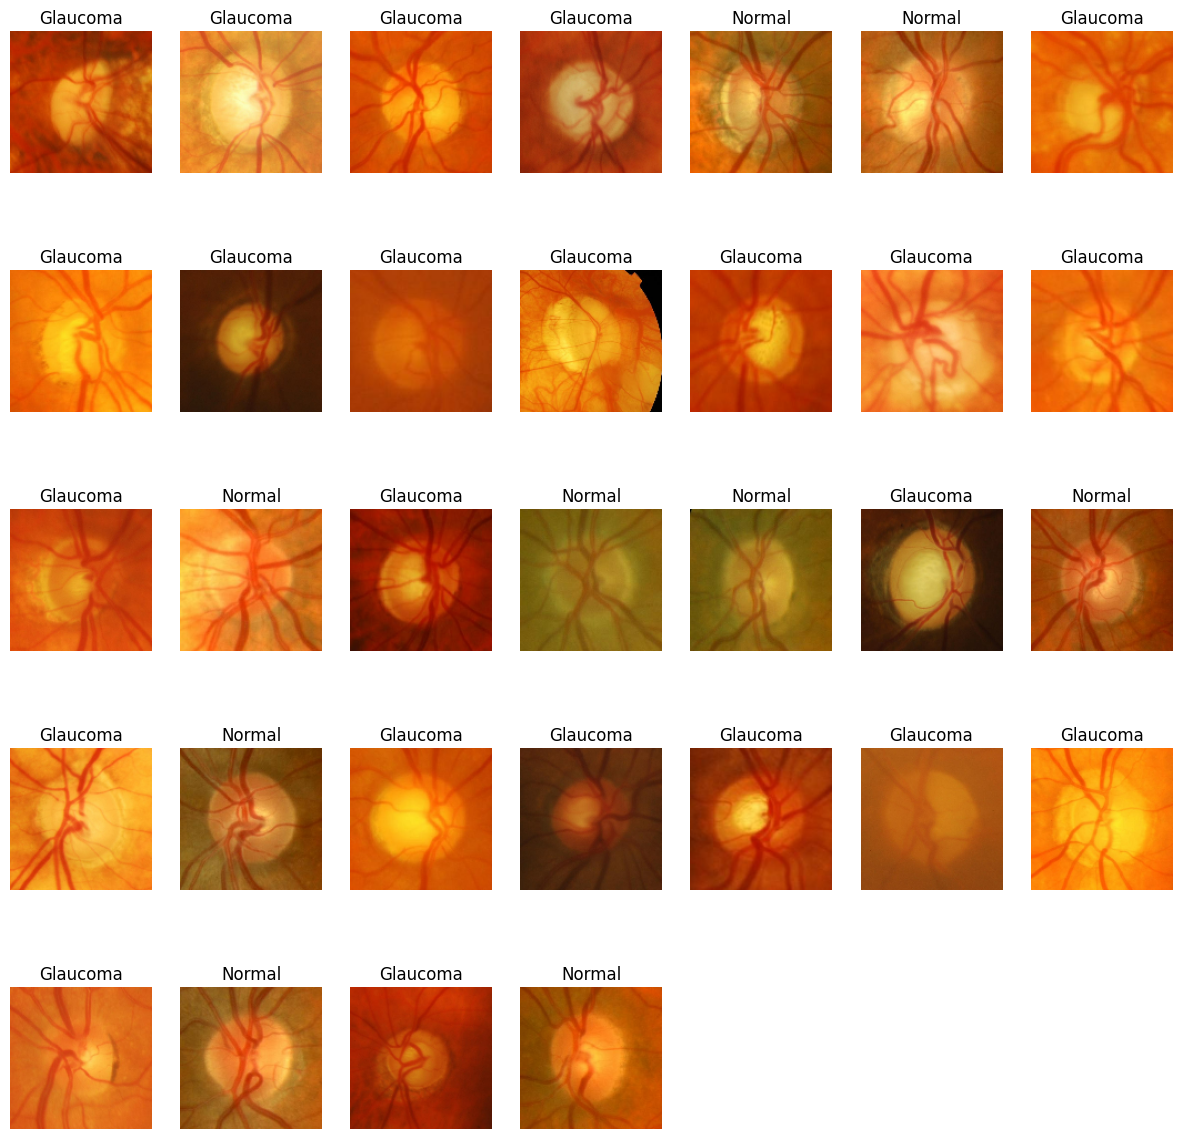

In [15]:
show_images(train_dataset)

## Validation

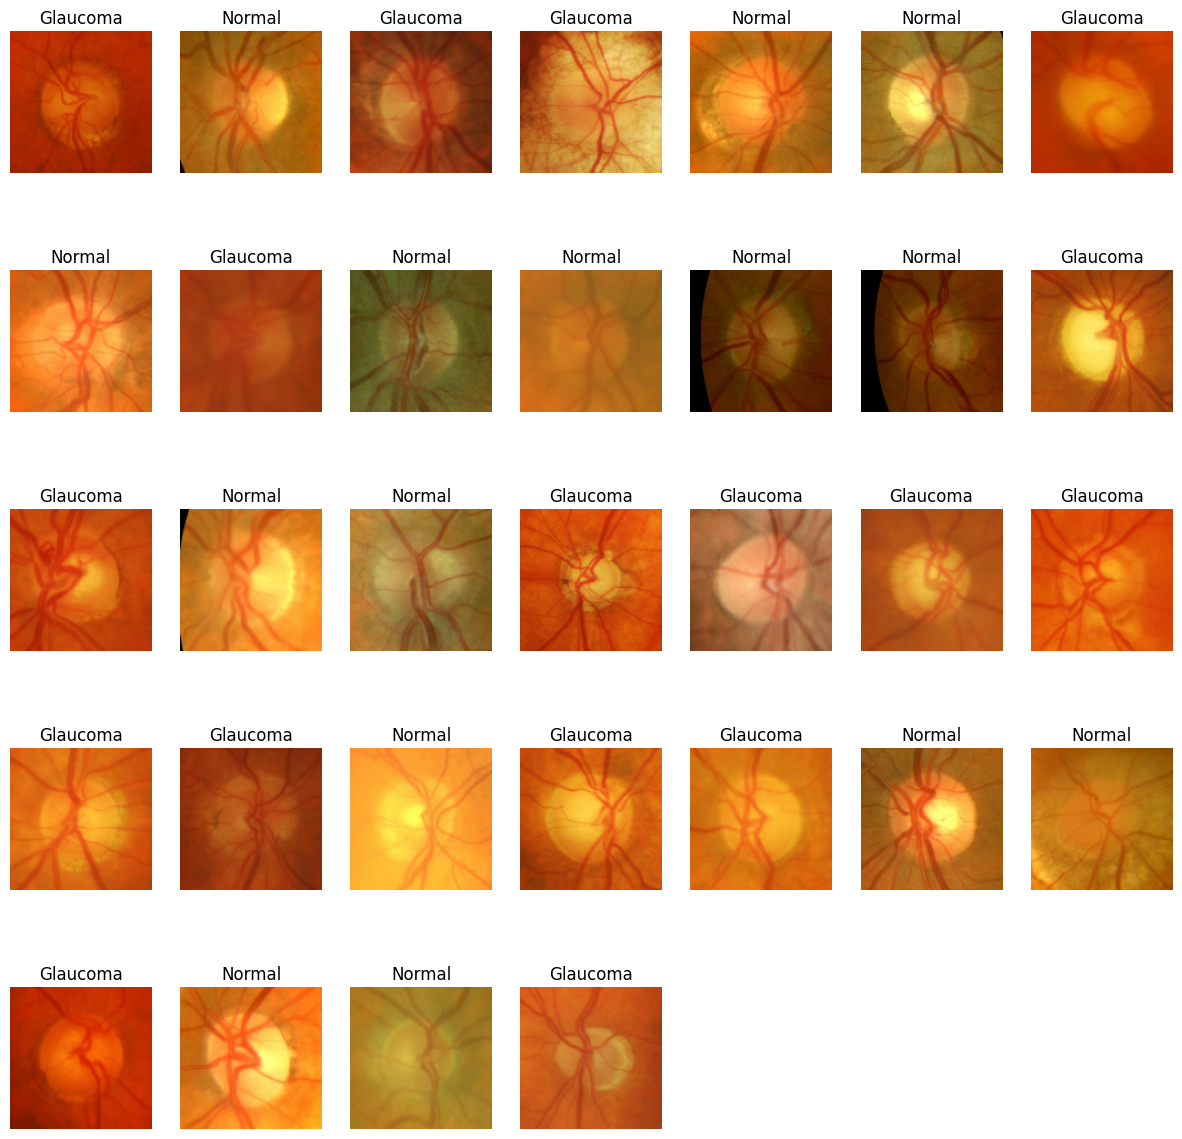

In [16]:
show_images(valid_dataset)

## Test

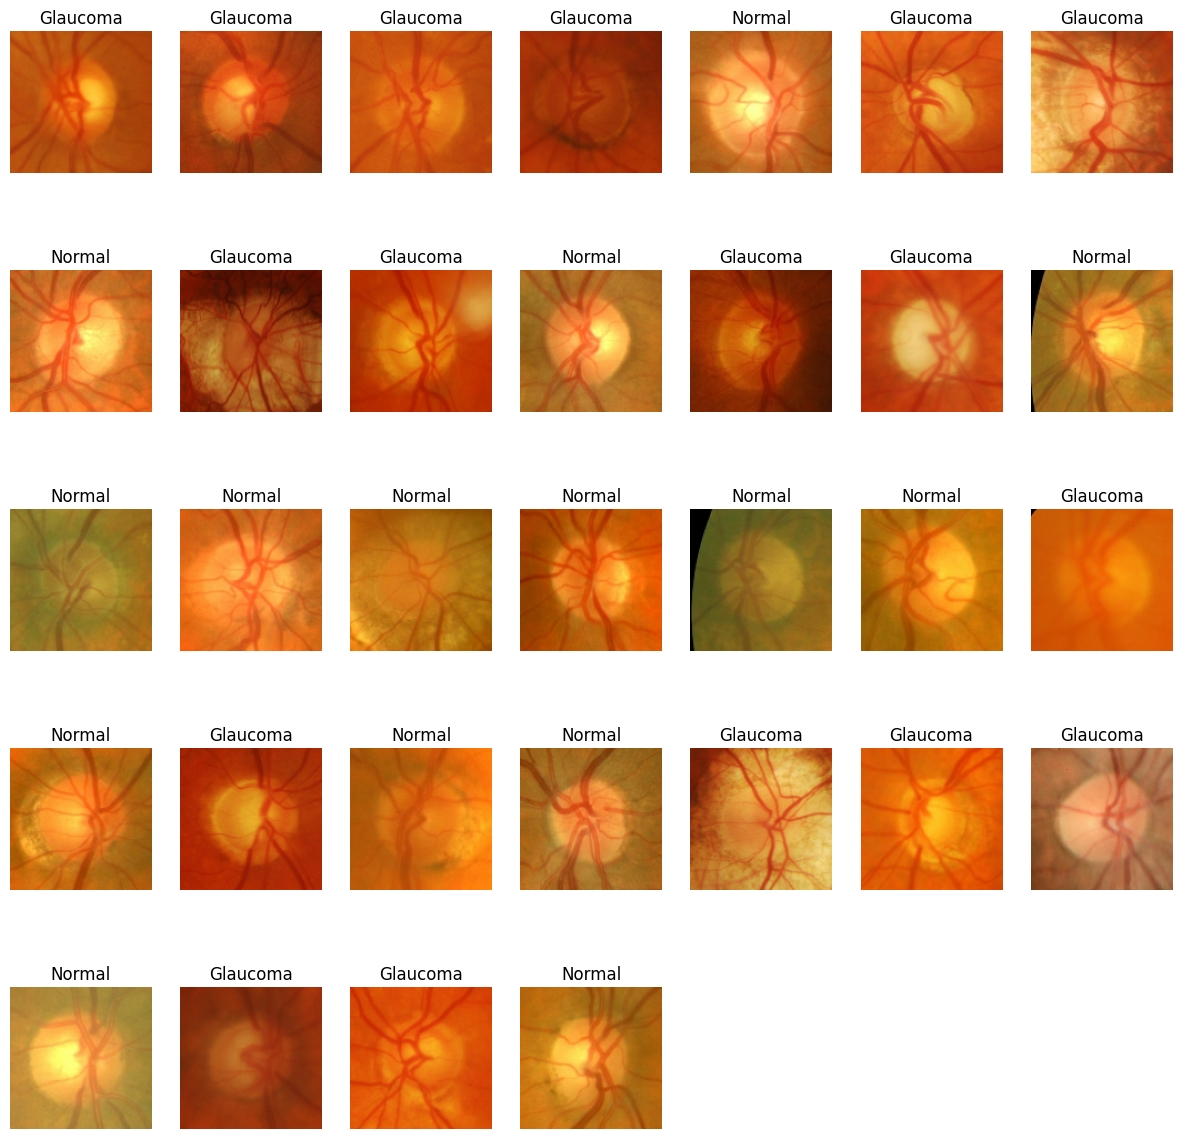

In [17]:
show_images(test_dataset)

In [3]:
def contar(dataset):
  glaucoma_count = 0
  normal_count = 0
  for im, lb in dataset:
    for l in lb:
      if l == 0:
        glaucoma_count += 1
      else:
        normal_count += 1
  print(f'Found {glaucoma_count} files belonging to glaucoma.')
  print(f'Found {normal_count} files belonging to normal.\n')
    
print(f"for train dataset: \n")
contar(train_dataset)
print(f"for validation dataset: \n")
contar(valid_dataset)
print(f"for test dataset: \n")
contar(test_dataset)


for train dataset: 

Found 285 files belonging to glaucoma.
Found 209 files belonging to normal.

for validation dataset: 

Found 33 files belonging to glaucoma.
Found 31 files belonging to normal.

for test dataset: 

Found 83 files belonging to glaucoma.
Found 64 files belonging to normal.



# Definir redes

En este caso se tendran 3 expertos, los cuales seran redes neuronales convolucionales tales como VGG19, DenseNet121 y ResNet50 con lo pesos pre-entrenados del set de datos de imagenet.

para la puerta de entrada, la cual decidira la importancia de cada modelo al momento de realizar entrengar una imagen, se utilizara una red neuronal convolucional personalizada con el fin de que esta pueda entrenar sus parametros y ajustarse a que modelos es mejor para cada imagen.

In [4]:
# Red neuronal convolucional (puerta de entrada)
# n = num de expertos

def gateNet(Input_layer, n, name='gate'):
  name = [name+str(i) for i in range(17)]

  # capas convolucionales + capas de pooling

  gate = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', name=name[0])(Input_layer)
  gate = keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', name=name[1])(gate)
  gate = keras.layers.MaxPooling2D(pool_size=(2,2), name=name[2])(gate)
  gate = keras.layers.Dropout(0.25, name=name[3])(gate)
  gate = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name=name[4])(gate)
  gate = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name=name[5])(gate)
  gate = keras.layers.MaxPooling2D(pool_size=(2,2), name=name[6])(gate)
  gate = keras.layers.Dropout(0.25, name=name[7])(gate)
  gate = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name=name[8])(gate)
  gate = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name=name[9])(gate)
  gate = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name=name[10])(gate)
  gate = keras.layers.MaxPooling2D(pool_size=(2,2), name=name[11])(gate)
  gate = keras.layers.Dropout(0.25, name=name[12])(gate)

  # feature maps + Dense layers
  gate = keras.layers.Flatten(name=name[13])(gate)
  gate = keras.layers.Dense(512, activation='relu', name=name[14])(gate)
  gate = keras.layers.Dropout(0.5, name=name[15])(gate)
  output = keras.layers.Dense(n, activation='softmax', name=name[16])(gate) # softmax?! -> posible cambio?

  model = keras.Model(inputs=Input_layer, outputs=output, name='gate')

  return model

In [5]:
# Descargar modelos base pre-entrenados

base_models = [
    keras.applications.VGG19(input_shape=(128,128,3),weights='imagenet', include_top=False),
    keras.applications.ResNet50(input_shape=(128,128,3),weights='imagenet', include_top=False),
    keras.applications.DenseNet121(input_shape=(128,128,3),weights='imagenet', include_top=False)
]
print(base_models)

#congelar parametros entrenables
for model in base_models:
  model.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[<Functional name=vgg19, built=True>, <Functional name=resnet50, built=True>, <Functional name=densenet121, built=True>]


### Ejemplo concatenacion de feature maps no aplanados

In [7]:
###ejemplo obtener featuremaps de un batch
test_fm = base_models[0](x_train[0])
test_fm2 = base_models[1](x_train[0])
print(f"test_fm shape: {test_fm.shape} and test_fm2 shape: {test_fm2.shape}")
conc_fm = tf.concat([test_fm, test_fm2], axis=-1)
print(f"shape of concatenated featur maps flattened: {conc_fm.shape}")


test_fm shape: (32, 4, 4, 512) and test_fm2 shape: (32, 4, 4, 2048)
shape of concatenated featur maps flattened: (32, 4, 4, 2560)


In [16]:
t1 = [[1, 2, 3], [4, 5, 6]]
t2 = [[7, 8, 9], [10, 11, 12]]
tf.concat([t1, t2], axis=-1)

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 1,  2,  3,  7,  8,  9],
       [ 4,  5,  6, 10, 11, 12]], dtype=int32)>

# Creacion de capa TopMExpertsFM
Esta capa calculara todos los feature maps de los expertos entregados y seleccionara el de los mejores m modelos para finalmente concatenarlos

In [83]:
class TopMExpertsFM(keras.layers.Layer):
    def __init__(self, m, experts, output_dim=512, **kwargs):
        super(TopMExpertsFM, self).__init__(**kwargs)
        self.m = m  # Numero de expertos a seleccionar
        self.experts = experts  # Lista de modelos CNN
        self.output_dim = output_dim  # Dimension de salida deseada para todos los feature maps de los expertos
        self.dense_layers = [keras.layers.Dense(output_dim) for _ in experts]

    def call(self, inputs, gate_output):
        batch_size = tf.shape(inputs)[0]
        num_experts = len(self.experts)

        # Obtener los indices de los top M expertos basados en la gate outputs para cada ejemplo del batch
        top_n_indices = tf.argsort(gate_output, direction='DESCENDING', axis=-1)
        top_m_indices = top_n_indices[:, :self.m]  # Seleccionar los indices de los top M expertos

        # Obtener los feature maps de cada experto y asegurar que tengan la misma dimension
        feature_maps = []
        for i in range(num_experts):
            expert_feature_map = self.experts[i](inputs)
            pooled_feature_map = tf.keras.layers.GlobalAveragePooling2D()(expert_feature_map)
            # Aplicar capas densas para unificar las dimensiones de los feature maps
            reduced_feature_map = self.dense_layers[i](pooled_feature_map)
            feature_maps.append(reduced_feature_map)
            
        # Stack feature maps along a new dimension (number of experts)
        feature_maps = tf.stack(feature_maps, axis=1)  # Shape: (batch_size, num_experts, ...)

        # Create indices for batch and expert selection
        batch_indices = tf.range(batch_size)[:, tf.newaxis]  # Shape: (batch_size, 1)
        batch_indices = tf.tile(batch_indices, [1, self.m])  # Shape: (batch_size, m)
        indices = tf.stack([batch_indices, top_m_indices], axis=-1)  # Shape: (batch_size, m, 2)

        # Gather the top M experts' feature maps
        selected_feature_maps = tf.gather_nd(feature_maps, indices)  # Shape: (batch_size, m, ...)

        # Concatenate the selected feature maps along the channel dimension
        concatenated_feature_maps = tf.concat(tf.unstack(selected_feature_maps, axis=1), axis=-1)
        

        return concatenated_feature_maps #retornar top_m_indices

### La misma clase pero con funciones para guardar y cargar el modelo

In [6]:
from tensorflow import keras
import tensorflow as tf

class TopMExpertsFM(keras.layers.Layer):
    def __init__(self, m, experts, output_dim=512, **kwargs):
        super(TopMExpertsFM, self).__init__(**kwargs)
        self.m = m  # Number of experts to select
        self.experts = experts  # List of CNN models (experts)
        self.output_dim = output_dim  # Desired output dimension for the experts' feature maps
        self.dense_layers = [keras.layers.Dense(output_dim) for _ in experts]

    def call(self, inputs, gate_output):
        batch_size = tf.shape(inputs)[0]
        num_experts = len(self.experts)

        # Get top M expert indices based on the gate output for each example in the batch
        top_n_indices = tf.argsort(gate_output, direction='DESCENDING', axis=-1)
        top_m_indices = top_n_indices[:, :self.m]  # Select indices of the top M experts

        # Get feature maps from each expert and ensure they have the same dimensions
        feature_maps = []
        for i in range(num_experts):
            expert_feature_map = self.experts[i](inputs)
            pooled_feature_map = tf.keras.layers.GlobalAveragePooling2D()(expert_feature_map)
            # Apply dense layers to unify the dimensions of the feature maps
            reduced_feature_map = self.dense_layers[i](pooled_feature_map)
            feature_maps.append(reduced_feature_map)

        # Stack feature maps along a new dimension (number of experts)
        feature_maps = tf.stack(feature_maps, axis=1)  # Shape: (batch_size, num_experts, ...)

        # Create indices for batch and expert selection
        batch_indices = tf.range(batch_size)[:, tf.newaxis]  # Shape: (batch_size, 1)
        batch_indices = tf.tile(batch_indices, [1, self.m])  # Shape: (batch_size, m)
        indices = tf.stack([batch_indices, top_m_indices], axis=-1)  # Shape: (batch_size, m, 2)

        # Gather the top M experts' feature maps
        selected_feature_maps = tf.gather_nd(feature_maps, indices)  # Shape: (batch_size, m, ...)

        # Concatenate the selected feature maps along the channel dimension
        concatenated_feature_maps = tf.concat(tf.unstack(selected_feature_maps, axis=1), axis=-1)

        return concatenated_feature_maps

    def get_config(self):
        base_config = super(TopMExpertsFM, self).get_config()
        config = {
            "m": self.m,
            "output_dim": self.output_dim,
            "experts": [keras.utils.serialize_keras_object(expert) for expert in self.experts],  # Serialize experts
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        experts_config = config.pop("experts")
        experts = [keras.utils.deserialize_keras_object(expert_config) for expert_config in experts_config]  # Deserialize experts
        return cls(experts=experts, **config)


# Flujo de capa TopMExpertsFM

1. Entrada: Se pasan los datos de entrada y una "puerta" (gate_output) que determina la relevancia de cada experto.

2. Procesar: Cada experto genera un mapa de características, se reducen sus dimensiones para unificar sus salidas, y se seleccionan los mejores M expertos en función de la "puerta".

3. Salida: Se concatenan los mapas de características de los expertos seleccionados para producir una única representación final.

<hr>

# CROSS VALIDATION

## Dataset completo para validación cruzada

In [7]:
#DATA AMBIGUA ALGUNOS BATCH DE 14. POR LO QUE INTENTEMOS ELIMINAR LOS BATCHES. x_train tiene 16 batches.
x_train_all = np.concatenate(x_train, axis=0) # concatenar para tener lista con imagenes (494, 128, 128, 3)
y_train_all = np.concatenate(y_train, axis=0)

x_valid_all = np.concatenate(x_valid, axis=0)
y_valid_all = np.concatenate(y_valid, axis=0)

x_test_all = np.concatenate(x_test, axis=0)
y_test_all = np.concatenate(y_test, axis=0)

x_train_cv = np.concatenate((x_train_all, x_valid_all, x_test_all), axis = 0)
y_train_cv = np.concatenate((y_train_all, y_valid_all, y_test_all), axis=0)

print(f"Shape de imagenes entrenaminto: {x_train_cv.shape}\nShape de labels de entrenamiento: {y_train_cv.shape}")

Shape de imagenes entrenaminto: (705, 128, 128, 3)
Shape de labels de entrenamiento: (705,)


### Función para matriz de confusión y métricas

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm_metrics(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    specificity = tn / (tn + fp)
    
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'f1_score': f1_score(y_true, y_pred),
               'Specificity': specificity,
               'Tasa de error': 1 - accuracy_score(y_true, y_pred)}
    
    for i in metrics:
      print(i,'',metrics[i])
    
    cm1 = ConfusionMatrixDisplay(cm).plot() #Mostrar matriz de confusion
    plt.show()
    return metrics

## Validacion Cruzada para un modelo MoE Seleccionando 1 experto

Training for fold 1 ...
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
I0000 00:00:1733019058.754677     105 service.cc:145] XLA service 0x7f56a0033350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733019058.754779     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733019058.754786     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733019094.123425     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - Accuracy: 0.5531 - loss: 1.0649 - val_Accuracy: 0.7324 - val_loss: 0.5164
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - Accuracy: 0.5801 - loss: 0.7765 - val_Accuracy: 0.8169 - val_loss: 0.4306
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - Accuracy: 0.6540 - loss: 0.6843 - val_Accuracy: 0.7887 - val_loss: 0.4655
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - Accuracy: 0.5928 - loss: 0.7104 - val_Accuracy: 0.8169 - val_loss: 0.4210
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - Accuracy: 0.6913 - loss: 0.5879 - val_Accuracy: 0.9014 - val_loss: 0.3197
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - Accuracy: 0.6833 - loss: 0.5645 - val_Accuracy: 0.8732 - val_loss: 0.3307
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - Accuracy: 0.7138 - loss: 0.5098 - val_Accuracy: 0.9014 - val_loss: 0.3143
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - Accuracy: 0.7300 - loss: 0.4622 - val_Accuracy: 0.8873 

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - Accuracy: 0.5072 - loss: 0.9041 - val_Accuracy: 0.7042 - val_loss: 0.5720
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - Accuracy: 0.5736 - loss: 0.9339 - val_Accuracy: 0.7887 - val_loss: 0.4683
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - Accuracy: 0.6560 - loss: 0.6692 - val_Accuracy: 0.6901 - val_loss: 0.4030
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - Accuracy: 0.6681 - loss: 0.6053 - val_Accuracy: 0.7465 - val_loss: 0.3835
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - Accuracy: 0.7025 - loss: 0.5696 - val_Accuracy: 0.7746 - val_loss: 0.3402
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - Accuracy: 0.6976 - loss: 0.5477 - val_Accuracy: 0.7887 - val_loss: 0.2939
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - Accuracy: 0.6592 - loss: 0.5335 - val_Accuracy: 0.7887 - val_loss: 0.2900
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - Accuracy: 0.7769 - loss: 0.4389 - val_Accuracy: 0.8169 -

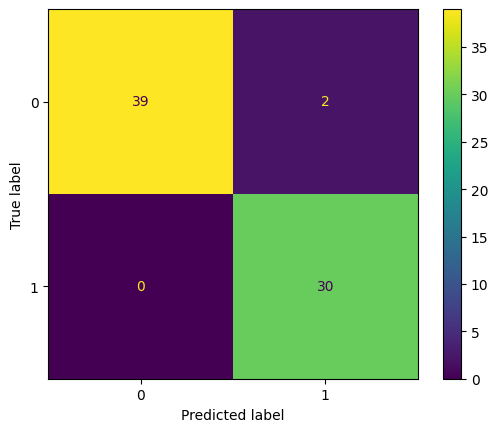

------------------------------------------------------------------------
confusion matrix & metrics fold: 2
Accuracy  0.7746478873239436
Recall  0.5666666666666667
Precision  0.85
f1_score  0.68
Specificity  0.926829268292683
Tasa de error  0.22535211267605637


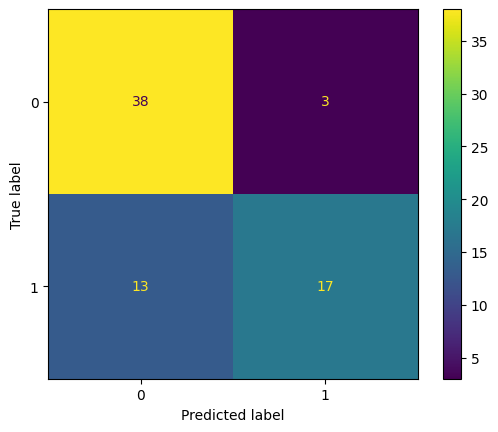

------------------------------------------------------------------------
confusion matrix & metrics fold: 3
Accuracy  0.5492957746478874
Recall  0.14285714285714285
Precision  0.7142857142857143
f1_score  0.23809523809523808
Specificity  0.9444444444444444
Tasa de error  0.45070422535211263


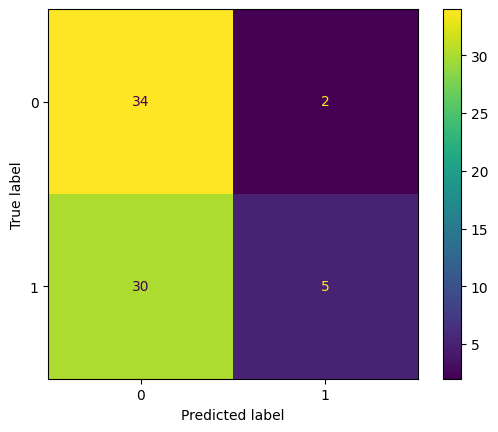

------------------------------------------------------------------------
confusion matrix & metrics fold: 4
Accuracy  0.8873239436619719
Recall  0.72
Precision  0.9473684210526315
f1_score  0.8181818181818181
Specificity  0.9782608695652174
Tasa de error  0.11267605633802813


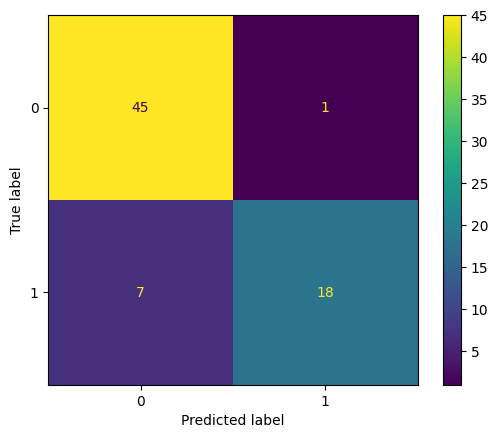

------------------------------------------------------------------------
confusion matrix & metrics fold: 5
Accuracy  0.9295774647887324
Recall  0.9459459459459459
Precision  0.9210526315789473
f1_score  0.9333333333333332
Specificity  0.9117647058823529
Tasa de error  0.07042253521126762


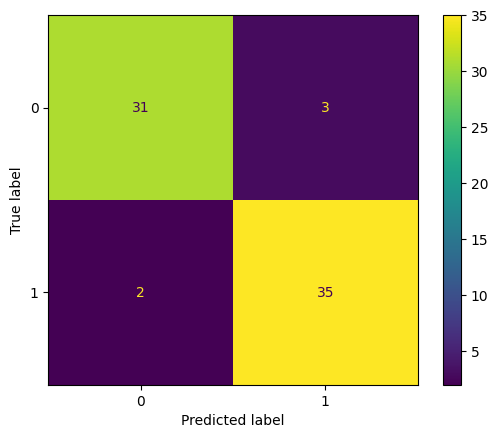

------------------------------------------------------------------------
confusion matrix & metrics fold: 6
Accuracy  0.8714285714285714
Recall  0.8064516129032258
Precision  0.8928571428571429
f1_score  0.8474576271186439
Specificity  0.9230769230769231
Tasa de error  0.12857142857142856


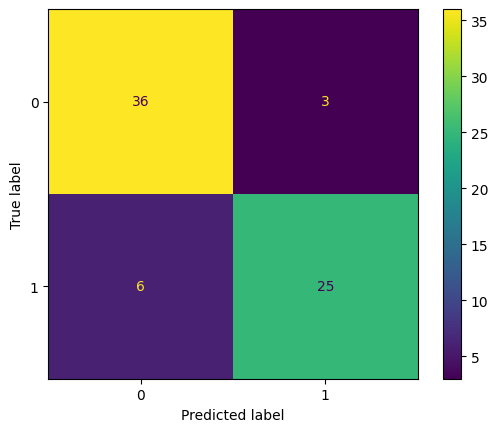

------------------------------------------------------------------------
confusion matrix & metrics fold: 7
Accuracy  0.5714285714285714
Recall  0.0
Precision  0.0
f1_score  0.0
Specificity  1.0
Tasa de error  0.4285714285714286


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


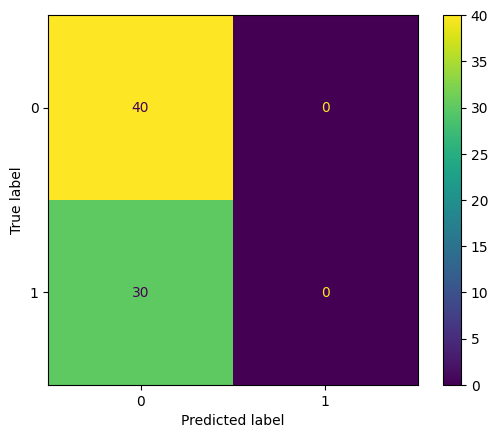

------------------------------------------------------------------------
confusion matrix & metrics fold: 8
Accuracy  0.8714285714285714
Recall  0.8518518518518519
Precision  0.8214285714285714
f1_score  0.8363636363636364
Specificity  0.8837209302325582
Tasa de error  0.12857142857142856


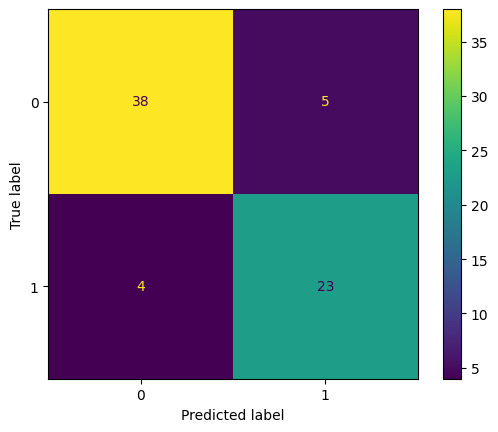

------------------------------------------------------------------------
confusion matrix & metrics fold: 9
Accuracy  0.9
Recall  0.9354838709677419
Precision  0.8529411764705882
f1_score  0.8923076923076922
Specificity  0.8717948717948718
Tasa de error  0.09999999999999998


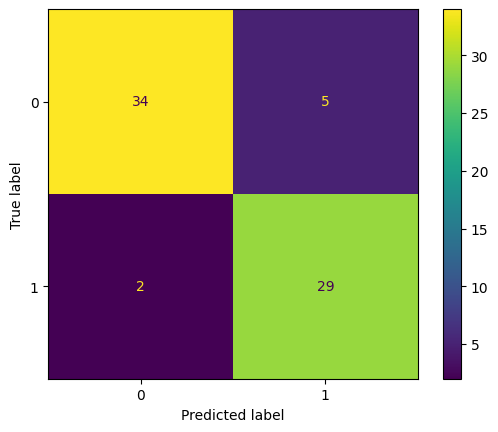

------------------------------------------------------------------------
confusion matrix & metrics fold: 10
Accuracy  0.9571428571428572
Recall  0.9310344827586207
Precision  0.9642857142857143
f1_score  0.9473684210526316
Specificity  0.975609756097561
Tasa de error  0.042857142857142816


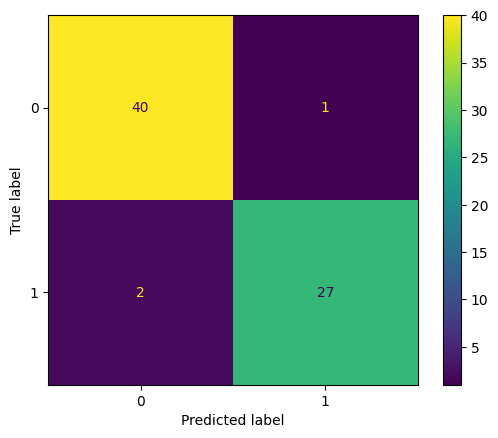

------------------------------------------------------------------------
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - val_loss: 0.6063883304595947 - val_accuracy: 97.183096408844%
------------------------------------------------------------------------
> Fold 2 - val_loss: 0.5617054104804993 - val_accuracy: 77.46478915214539%
------------------------------------------------------------------------
> Fold 3 - val_loss: 0.6011167764663696 - val_accuracy: 54.92957830429077%
------------------------------------------------------------------------
> Fold 4 - val_loss: 0.26791903376579285 - val_accuracy: 88.73239159584045%
------------------------------------------------------------------------
> Fold 5 - val_loss: 0.23292316496372223 - val_accuracy: 92.95774698257446%
------------------------------------------------------------------------
> Fold 6 - val_loss: 0.832

In [10]:
#validacion cruzada y metricas
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
kfold = KFold(n_splits=10, shuffle=True, random_state=42) #k = 10 folds
fold_n = 1 #numero de fold

# Definir contenedores de score por fold
acc_per_fold = []
loss_per_fold = []

# Contenedores de matrices de confusion para cada fold
y_preds = []
y_trues = []

for train, valid in kfold.split(x_train_cv, y_train_cv):
    #crear modelo
    
    # crear la entrada para las imagenes
    input_layer = keras.layers.Input(shape=(128,128,3))
    # crear la red Gate
    gate_network = gateNet(input_layer, len(base_models))
    #Obtener salida de la red gate
    gate_output = gate_network(input_layer)
    # Crear la capa TopMExpertsFM
    top_m_layer = TopMExpertsFM(m=1, experts=base_models, output_dim=512)
    concatenated_features = top_m_layer(input_layer, gate_output)
    x = keras.layers.Dense(512, activation='relu')(concatenated_features)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    
    MoeModel = keras.models.Model(inputs = input_layer, outputs = output, name=f"MoeModel_fold_{fold_n}")

    MoeModel.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['Accuracy'])

    #print("--"*120)
    print(f"Training for fold {fold_n} ...")

    # logs for tensorboard
    logs = './logs/select1/'
    tb = TensorBoard(log_dir=logs+MoeModel.name)
    #Entrenar modelo
    MoeModel.fit(x_train_cv[train], y_train_cv[train],
             validation_data=(x_train_cv[valid], y_train_cv[valid]),
             epochs = epochs, #100
             batch_size=batch_size, #32
             callbacks=[tb])
    
    #Puntuacion (val_loss y val_accuracy)
    scores = MoeModel.evaluate(x_train_cv[valid], y_train_cv[valid], verbose=0)
    print(f"Score for fold {fold_n}: {MoeModel.metrics_names[0]} of {scores[0]}; {MoeModel.metrics_names[1]} of {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predicciones en set de validación
    print(f"Making predictions for fold {fold_n}...")
    y_pred_k = MoeModel.predict(x_train_cv[valid])
    # Binarizar probabilidades umbral 0.5
    y_pred_k = np.where(y_pred_k >= 0.5, 1, 0)
    y_true_k = y_train_cv[valid]
    
    # almacenar predicciones y labels de cada fold
    y_trues.append(y_true_k)
    y_preds.append(y_pred_k)

    #aumentar contador fold
    fold_n += 1



avg_metrics_list = [] # lista para metricas promedio

# Matrices de confusion
print('-'*72)
print('Confusion matrix & Metrics per fold:')
print('-'*72)
for i in range(0, len(y_preds)):
    print(f'confusion matrix & metrics fold: {i+1}')
    metrics = plot_cm_metrics(y_trues[i], y_preds[i])
    avg_metrics_list.append(metrics)
    print('-'*72)

# == Provide average scores ==
print('-'*72)
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('-'*72)
  print(f'> Fold {i+1} - val_loss: {loss_per_fold[i]} - val_accuracy: {acc_per_fold[i]}%')
print('-'*72)
print('Average scores for all folds:')
print(f'> val_Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> val_Loss: {np.mean(loss_per_fold)}')
print('-'*72)

# == provide average metrics ==
print('Average Metrics for all folds:')

# Inicializar un diccionario para acumular los valores
suma_metricas = {key: 0 for key in avg_metrics_list[0]}

# Sumar los valores de cada métrica
for diccionario in avg_metrics_list:
    for clave, valor in diccionario.items():
        suma_metricas[clave] += valor

# Dividir entre el número de diccionarios para obtener el promedio
promedio_metricas = {clave: suma / len(avg_metrics_list) for clave, suma in suma_metricas.items()}

print("Promedio de métricas:")
for clave, valor in promedio_metricas.items():
    print(f"{clave}: {valor:.4f}")
print('-'*72)


## View Tensorboard logs per fold

In [ ]:
%tensorboard --logdir logs

## Validacion Cruzada para un modelo MoE Seleccionando los mejores 2 expertos

Training for fold 1 ...
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
I0000 00:00:1733024613.209178     103 service.cc:145] XLA service 0x7f9cc8026bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733024613.209232     103 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733024613.209236     103 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733024647.863213     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - Accuracy: 0.5134 - loss: 0.9308 - val_Accuracy: 0.5775 - val_loss: 0.7272
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - Accuracy: 0.5429 - loss: 0.9398 - val_Accuracy: 0.5775 - val_loss: 0.6840
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - Accuracy: 0.5255 - loss: 0.7961 - val_Accuracy: 0.5775 - val_loss: 0.6858
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - Accuracy: 0.5549 - loss: 0.7363 - val_Accuracy: 0.5775 - val_loss: 0.6814
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - Accuracy: 0.6403 - loss: 0.6443 - val_Accuracy: 0.5775 - val_loss: 0.6734
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - Accuracy: 0.6306 - loss: 0.6440 - val_Accuracy: 0.5775 - val_loss: 0.6774
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - Accuracy: 0.6566 - loss: 0.6058 - val_Accuracy: 0.5775 - val_loss: 0.6801
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - Accuracy: 0.6783 - loss: 0.5678 - val_Accuracy: 0.5775 

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - Accuracy: 0.5066 - loss: 1.0433 - val_Accuracy: 0.6620 - val_loss: 0.6577
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - Accuracy: 0.5231 - loss: 1.0063 - val_Accuracy: 0.5634 - val_loss: 0.6763
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - Accuracy: 0.5721 - loss: 0.7820 - val_Accuracy: 0.6620 - val_loss: 0.6129
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - Accuracy: 0.6233 - loss: 0.6775 - val_Accuracy: 0.6620 - val_loss: 0.5373
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - Accuracy: 0.6602 - loss: 0.6465 - val_Accuracy: 0.7465 - val_loss: 0.5095
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - Accuracy: 0.6646 - loss: 0.6026 - val_Accuracy: 0.7183 - val_loss: 0.5032
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - Accuracy: 0.6955 - loss: 0.6216 - val_Accuracy: 0.7324 - val_loss: 0.4877
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - Accuracy: 0.7063 - loss: 0.5235 - val_Accuracy: 0.7465 -

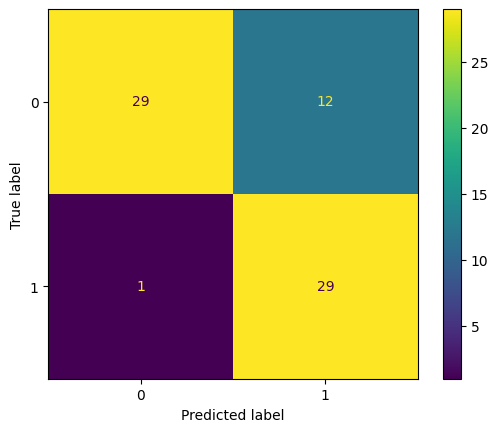

------------------------------------------------------------------------
confusion matrix & metrics fold: 2
Accuracy  0.9295774647887324
Recall  0.9
Precision  0.9310344827586207
f1_score  0.9152542372881356
Specificity  0.9512195121951219
Tasa de error  0.07042253521126762


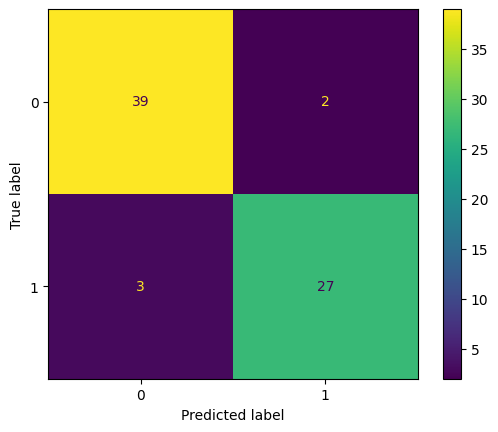

------------------------------------------------------------------------
confusion matrix & metrics fold: 3
Accuracy  0.8450704225352113
Recall  0.6857142857142857
Precision  1.0
f1_score  0.8135593220338984
Specificity  1.0
Tasa de error  0.15492957746478875


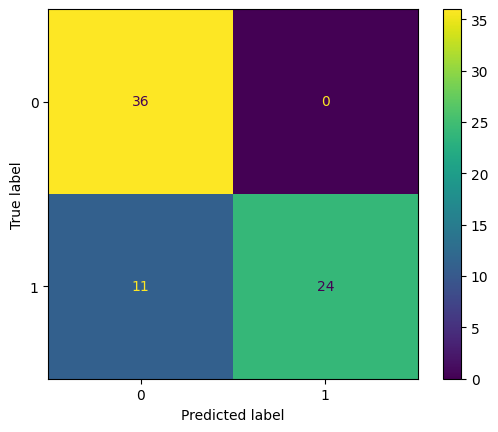

------------------------------------------------------------------------
confusion matrix & metrics fold: 4
Accuracy  0.9436619718309859
Recall  0.88
Precision  0.9565217391304348
f1_score  0.9166666666666666
Specificity  0.9782608695652174
Tasa de error  0.05633802816901412


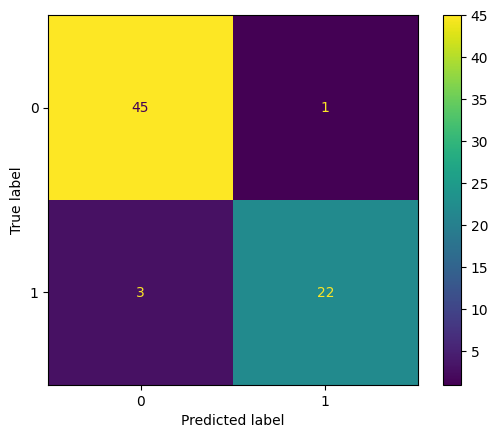

------------------------------------------------------------------------
confusion matrix & metrics fold: 5
Accuracy  0.9014084507042254
Recall  0.8378378378378378
Precision  0.96875
f1_score  0.8985507246376812
Specificity  0.9705882352941176
Tasa de error  0.09859154929577463


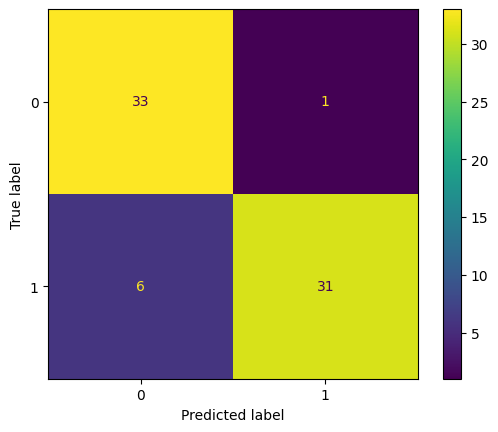

------------------------------------------------------------------------
confusion matrix & metrics fold: 6
Accuracy  0.8857142857142857
Recall  0.8064516129032258
Precision  0.9259259259259259
f1_score  0.8620689655172414
Specificity  0.9487179487179487
Tasa de error  0.11428571428571432


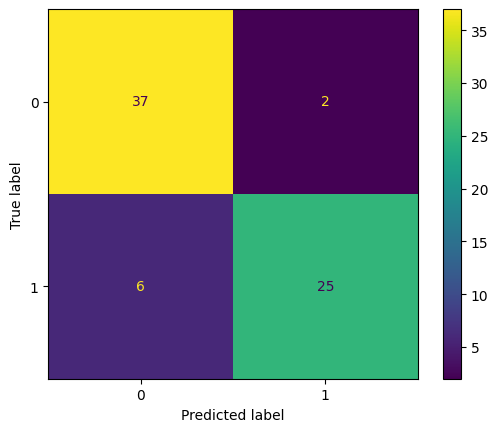

------------------------------------------------------------------------
confusion matrix & metrics fold: 7
Accuracy  0.8428571428571429
Recall  0.8
Precision  0.8275862068965517
f1_score  0.8135593220338982
Specificity  0.875
Tasa de error  0.15714285714285714


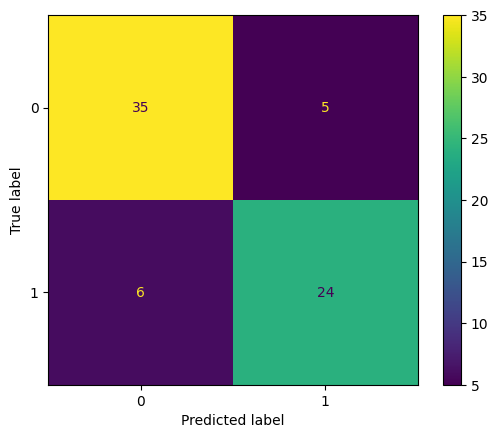

------------------------------------------------------------------------
confusion matrix & metrics fold: 8
Accuracy  0.8428571428571429
Recall  0.7407407407407407
Precision  0.8333333333333334
f1_score  0.7843137254901961
Specificity  0.9069767441860465
Tasa de error  0.15714285714285714


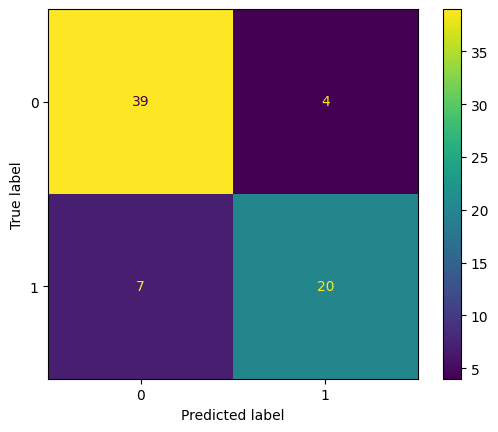

------------------------------------------------------------------------
confusion matrix & metrics fold: 9
Accuracy  0.9
Recall  0.9354838709677419
Precision  0.8529411764705882
f1_score  0.8923076923076922
Specificity  0.8717948717948718
Tasa de error  0.09999999999999998


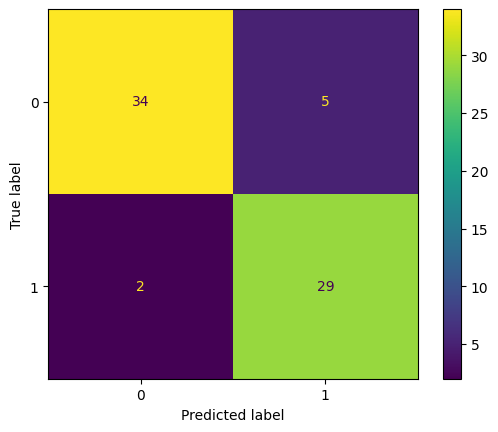

------------------------------------------------------------------------
confusion matrix & metrics fold: 10
Accuracy  0.9428571428571428
Recall  0.9310344827586207
Precision  0.9310344827586207
f1_score  0.9310344827586207
Specificity  0.9512195121951219
Tasa de error  0.05714285714285716


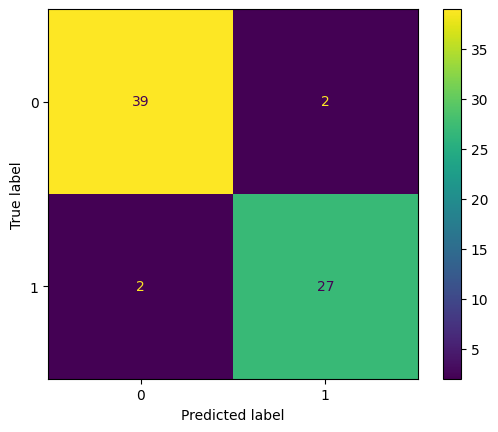

------------------------------------------------------------------------
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - val_loss: 0.5156739354133606 - val_accuracy: 81.69013857841492%
------------------------------------------------------------------------
> Fold 2 - val_loss: 0.24589695036411285 - val_accuracy: 92.95774698257446%
------------------------------------------------------------------------
> Fold 3 - val_loss: 0.2896796464920044 - val_accuracy: 84.50704216957092%
------------------------------------------------------------------------
> Fold 4 - val_loss: 0.25825032591819763 - val_accuracy: 94.36619877815247%
------------------------------------------------------------------------
> Fold 5 - val_loss: 0.31946292519569397 - val_accuracy: 90.14084339141846%
------------------------------------------------------------------------
> Fold 6 - val_loss: 0.

In [9]:
#validacion cruzada y metricas
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
kfold = KFold(n_splits=10, shuffle=True, random_state=42) #k = 10 folds
fold_n = 1 #numero de fold

# Definir contenedores de score por fold
acc_per_fold = []
loss_per_fold = []

# Contenedores de matrices de confusion para cada fold
y_preds = []
y_trues = []

for train, valid in kfold.split(x_train_cv, y_train_cv):
    #crear modelo
    
    # crear la entrada para las imagenes
    input_layer = keras.layers.Input(shape=(128,128,3))
    # crear la red Gate
    gate_network = gateNet(input_layer, len(base_models))
    #Obtener salida de la red gate
    gate_output = gate_network(input_layer)
    # Crear la capa TopMExpertsFM
    top_m_layer = TopMExpertsFM(m=2, experts=base_models, output_dim=512)
    concatenated_features = top_m_layer(input_layer, gate_output)
    x = keras.layers.Dense(512, activation='relu')(concatenated_features)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    
    MoeModel = keras.models.Model(inputs = input_layer, outputs = output, name=f"MoeModel_fold_{fold_n}")

    MoeModel.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['Accuracy'])

    #print("--"*120)
    print(f"Training for fold {fold_n} ...")

    # logs for tensorboard
    logs = './logs/select2/'
    tb = TensorBoard(log_dir=logs+MoeModel.name)
    #Entrenar modelo
    MoeModel.fit(x_train_cv[train], y_train_cv[train],
             validation_data=(x_train_cv[valid], y_train_cv[valid]),
             epochs = epochs, #100
             batch_size=batch_size, #32
             callbacks=[tb])
    
    #Puntuacion (val_loss y val_accuracy)
    scores = MoeModel.evaluate(x_train_cv[valid], y_train_cv[valid], verbose=0)
    print(f"Score for fold {fold_n}: {MoeModel.metrics_names[0]} of {scores[0]}; {MoeModel.metrics_names[1]} of {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predicciones en set de validación
    print(f"Making predictions for fold {fold_n}...")
    y_pred_k = MoeModel.predict(x_train_cv[valid])
    # Binarizar probabilidades umbral 0.5
    y_pred_k = np.where(y_pred_k >= 0.5, 1, 0)
    y_true_k = y_train_cv[valid]
    
    # almacenar predicciones y labels de cada fold
    y_trues.append(y_true_k)
    y_preds.append(y_pred_k)

    #aumentar contador fold
    fold_n += 1



avg_metrics_list = [] # lista para metricas promedio

# Matrices de confusion
print('-'*72)
print('Confusion matrix & Metrics per fold:')
print('-'*72)
for i in range(0, len(y_preds)):
    print(f'confusion matrix & metrics fold: {i+1}')
    metrics = plot_cm_metrics(y_trues[i], y_preds[i])
    avg_metrics_list.append(metrics)
    print('-'*72)

# == Provide average scores ==
print('-'*72)
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('-'*72)
  print(f'> Fold {i+1} - val_loss: {loss_per_fold[i]} - val_accuracy: {acc_per_fold[i]}%')
print('-'*72)
print('Average scores for all folds:')
print(f'> val_Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> val_Loss: {np.mean(loss_per_fold)}')
print('-'*72)

# == provide average metrics ==
print('Average Metrics for all folds:')

# Inicializar un diccionario para acumular los valores
suma_metricas = {key: 0 for key in avg_metrics_list[0]}

# Sumar los valores de cada métrica
for diccionario in avg_metrics_list:
    for clave, valor in diccionario.items():
        suma_metricas[clave] += valor

# Dividir entre el número de diccionarios para obtener el promedio
promedio_metricas = {clave: suma / len(avg_metrics_list) for clave, suma in suma_metricas.items()}

print("Promedio de métricas:")
for clave, valor in promedio_metricas.items():
    print(f"{clave}: {valor:.4f}")
print('-'*72)


In [10]:
!zip -r logs.zip logs/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: logs/ (stored 0%)
  adding: logs/select2/ (stored 0%)
  adding: logs/select2/MoeModel_fold_5/ (stored 0%)
  adding: logs/select2/MoeModel_fold_5/train/ (stored 0%)
  adding: logs/select2/MoeModel_fold_5/train/events.out.tfevents.1733026241.dbee4cf68d36.30.8.v2 (deflated 94%)
  adding: logs/select2/MoeModel_fold_5/validation/ (stored 0%)
  adding: logs/select2/MoeModel_fold_5/validation/events.out.tfevents.1733026299.dbee4cf68d36.30.9.v2 (deflated 80%)
  adding: logs/select2/MoeModel_fold_7/ (stored 0%)
  adding: logs/select2/MoeModel_fold_7/train/ (stored 0%)
  adding: logs/select2/MoeModel_fold_7/train/events.out.tfevents.1733027067.dbee4cf68d36.30.12.v2 (deflated 94%)
  adding: logs/select2/MoeModel_fold_7/validation/ (stored 0%)
  adding: logs/select2/MoeModel_fold_7/validation/events.out.tfevents.1733027127.dbee4cf68d36.30.13.v2 (deflated 80%)
  adding: logs/select2/MoeModel_fold_2/ (stored 0%)
  adding: logs/select2/MoeModel_fold_2/train/ (stored 0%)
  adding: logs/selec

## View Tensorboard logs per fold

In [15]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Validacion Cruzada para un modelo MoE Seleccionando los mejores 3 expertos

Training for fold 1 ...
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
I0000 00:00:1733029076.802301     105 service.cc:145] XLA service 0x7baffc0028a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733029076.802364     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733029076.802368     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733029110.900826     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - Accuracy: 0.5488 - loss: 0.9868 - val_Accuracy: 0.4507 - val_loss: 0.7272
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - Accuracy: 0.5725 - loss: 0.9199 - val_Accuracy: 0.7746 - val_loss: 0.5340
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - Accuracy: 0.6485 - loss: 0.7065 - val_Accuracy: 0.8310 - val_loss: 0.5827
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - Accuracy: 0.6170 - loss: 0.6818 - val_Accuracy: 0.7324 - val_loss: 0.5160
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - Accuracy: 0.7206 - loss: 0.5773 - val_Accuracy: 0.7887 - val_loss: 0.4363
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - Accuracy: 0.7839 - loss: 0.4816 - val_Accuracy: 0.8873 - val_loss: 0.3406
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - Accuracy: 0.8462 - loss: 0.3555 - val_Accuracy: 0.8873 - val_loss: 0.3051
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - Accuracy: 0.8837 - loss: 0.2754 - val_Accuracy: 0.8592 

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - Accuracy: 0.5202 - loss: 1.0730 - val_Accuracy: 0.6056 - val_loss: 0.5891
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - Accuracy: 0.5833 - loss: 0.9654 - val_Accuracy: 0.7324 - val_loss: 0.6083
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - Accuracy: 0.6325 - loss: 0.7750 - val_Accuracy: 0.8592 - val_loss: 0.4512
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - Accuracy: 0.6939 - loss: 0.5938 - val_Accuracy: 0.8451 - val_loss: 0.3188
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - Accuracy: 0.7892 - loss: 0.4823 - val_Accuracy: 0.9155 - val_loss: 0.3350
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - Accuracy: 0.8061 - loss: 0.4625 - val_Accuracy: 0.9014 - val_loss: 0.3089
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - Accuracy: 0.8544 - loss: 0.3519 - val_Accuracy: 0.9155 - val_loss: 0.2561
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - Accuracy: 0.8813 - loss: 0.3390 - val_Accuracy: 0.9296 -

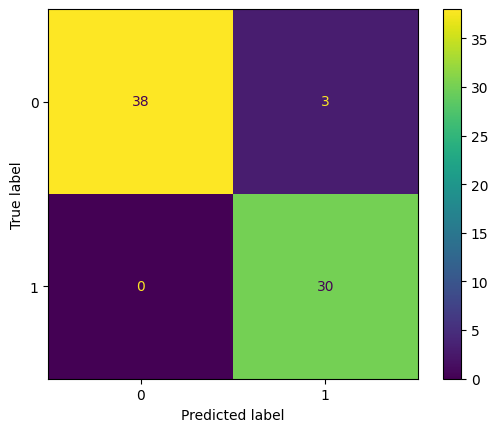

------------------------------------------------------------------------
confusion matrix & metrics fold: 2
Accuracy  0.9577464788732394
Recall  0.9666666666666667
Precision  0.9354838709677419
f1_score  0.9508196721311476
Specificity  0.9512195121951219
Tasa de error  0.04225352112676062


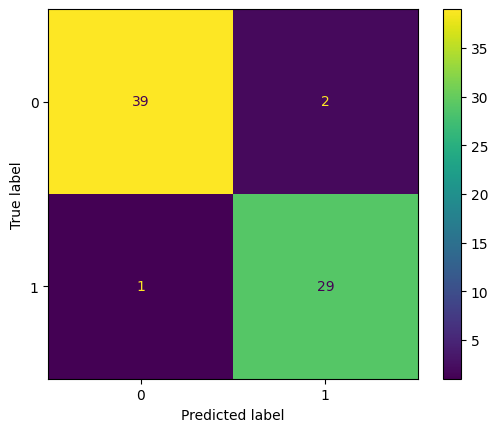

------------------------------------------------------------------------
confusion matrix & metrics fold: 3
Accuracy  0.9577464788732394
Recall  0.9142857142857143
Precision  1.0
f1_score  0.955223880597015
Specificity  1.0
Tasa de error  0.04225352112676062


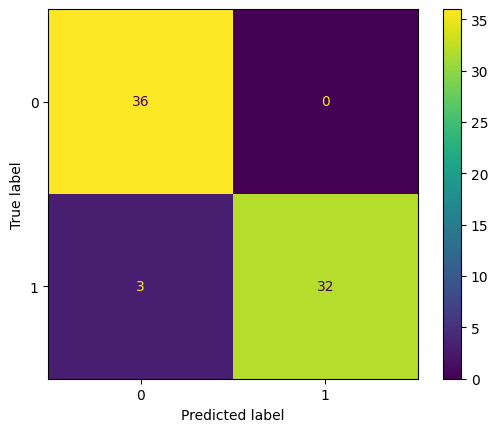

------------------------------------------------------------------------
confusion matrix & metrics fold: 4
Accuracy  0.9295774647887324
Recall  0.92
Precision  0.8846153846153846
f1_score  0.9019607843137256
Specificity  0.9347826086956522
Tasa de error  0.07042253521126762


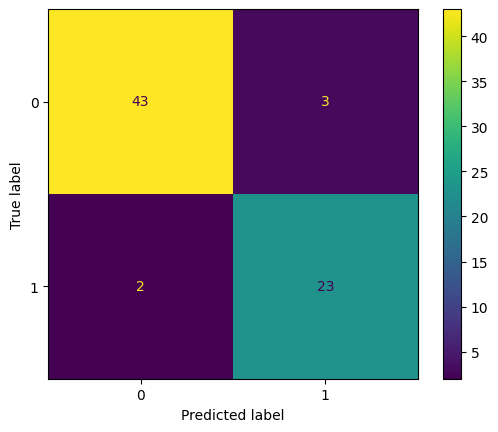

------------------------------------------------------------------------
confusion matrix & metrics fold: 5
Accuracy  0.9577464788732394
Recall  0.972972972972973
Precision  0.9473684210526315
f1_score  0.9599999999999999
Specificity  0.9411764705882353
Tasa de error  0.04225352112676062


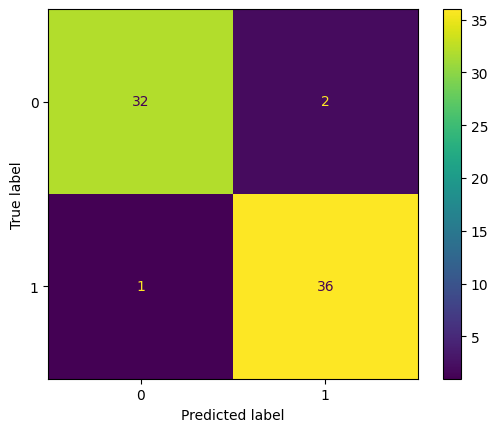

------------------------------------------------------------------------
confusion matrix & metrics fold: 6
Accuracy  0.9
Recall  0.8709677419354839
Precision  0.9
f1_score  0.8852459016393444
Specificity  0.9230769230769231
Tasa de error  0.09999999999999998


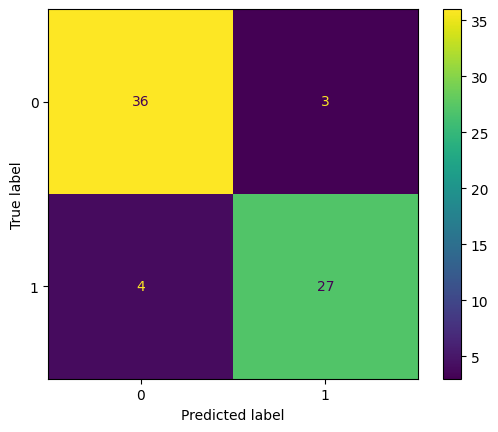

------------------------------------------------------------------------
confusion matrix & metrics fold: 7
Accuracy  0.9428571428571428
Recall  0.8666666666666667
Precision  1.0
f1_score  0.9285714285714286
Specificity  1.0
Tasa de error  0.05714285714285716


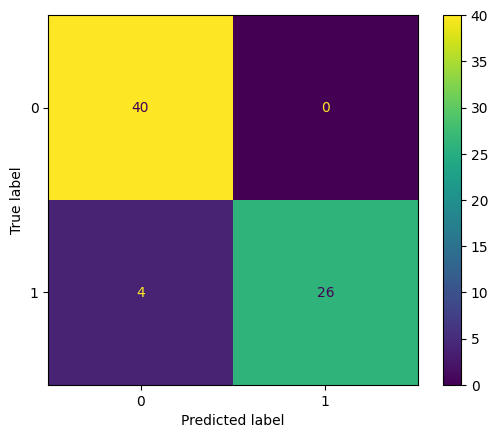

------------------------------------------------------------------------
confusion matrix & metrics fold: 8
Accuracy  0.9285714285714286
Recall  0.9259259259259259
Precision  0.8928571428571429
f1_score  0.9090909090909091
Specificity  0.9302325581395349
Tasa de error  0.0714285714285714


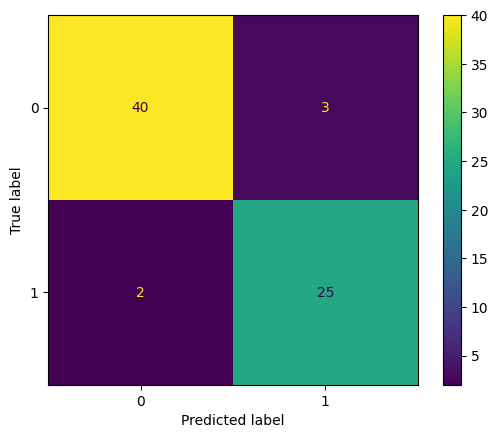

------------------------------------------------------------------------
confusion matrix & metrics fold: 9
Accuracy  0.9285714285714286
Recall  0.9032258064516129
Precision  0.9333333333333333
f1_score  0.9180327868852459
Specificity  0.9487179487179487
Tasa de error  0.0714285714285714


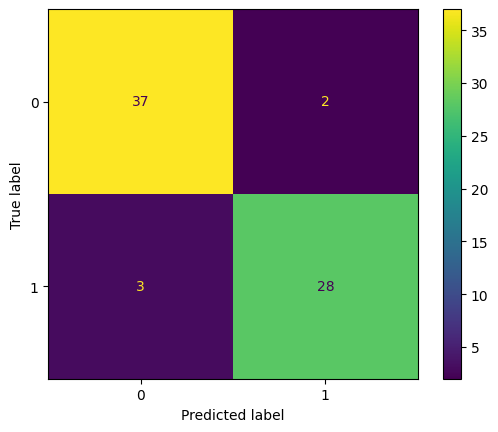

------------------------------------------------------------------------
confusion matrix & metrics fold: 10
Accuracy  0.9571428571428572
Recall  0.9310344827586207
Precision  0.9642857142857143
f1_score  0.9473684210526316
Specificity  0.975609756097561
Tasa de error  0.042857142857142816


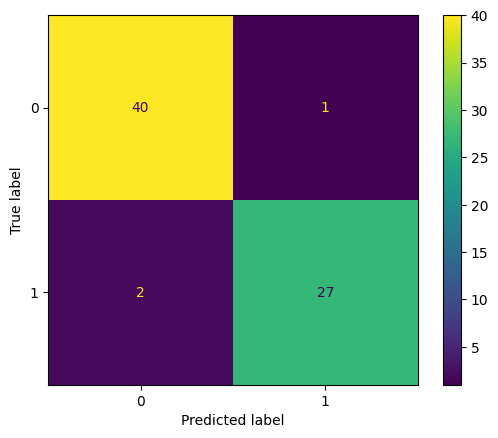

------------------------------------------------------------------------
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - val_loss: 0.9743926525115967 - val_accuracy: 95.77465057373047%
------------------------------------------------------------------------
> Fold 2 - val_loss: 0.30002254247665405 - val_accuracy: 95.77465057373047%
------------------------------------------------------------------------
> Fold 3 - val_loss: 0.23980505764484406 - val_accuracy: 95.77465057373047%
------------------------------------------------------------------------
> Fold 4 - val_loss: 0.1149129569530487 - val_accuracy: 92.95774698257446%
------------------------------------------------------------------------
> Fold 5 - val_loss: 0.1602252572774887 - val_accuracy: 95.77465057373047%
------------------------------------------------------------------------
> Fold 6 - val_loss: 0.8

In [9]:
#validacion cruzada y metricas
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
kfold = KFold(n_splits=10, shuffle=True, random_state=42) #k = 10 folds
fold_n = 1 #numero de fold

# Definir contenedores de score por fold
acc_per_fold = []
loss_per_fold = []

# Contenedores de matrices de confusion para cada fold
y_preds = []
y_trues = []

for train, valid in kfold.split(x_train_cv, y_train_cv):
    #crear modelo
    
    # crear la entrada para las imagenes
    input_layer = keras.layers.Input(shape=(128,128,3))
    # crear la red Gate
    gate_network = gateNet(input_layer, len(base_models))
    #Obtener salida de la red gate
    gate_output = gate_network(input_layer)
    # Crear la capa TopMExpertsFM
    top_m_layer = TopMExpertsFM(m=3, experts=base_models, output_dim=512)
    concatenated_features = top_m_layer(input_layer, gate_output)
    x = keras.layers.Dense(512, activation='relu')(concatenated_features)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    
    MoeModel = keras.models.Model(inputs = input_layer, outputs = output, name=f"MoeModel_fold_{fold_n}")

    MoeModel.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['Accuracy'])

    #print("--"*120)
    print(f"Training for fold {fold_n} ...")

    # logs for tensorboard
    logs = './logs/select3/'
    tb = TensorBoard(log_dir=logs+MoeModel.name)
    #Entrenar modelo
    MoeModel.fit(x_train_cv[train], y_train_cv[train],
             validation_data=(x_train_cv[valid], y_train_cv[valid]),
             epochs = epochs, #100
             batch_size=batch_size, #32
             callbacks=[tb])
    
    #Puntuacion (val_loss y val_accuracy)
    scores = MoeModel.evaluate(x_train_cv[valid], y_train_cv[valid], verbose=0)
    print(f"Score for fold {fold_n}: {MoeModel.metrics_names[0]} of {scores[0]}; {MoeModel.metrics_names[1]} of {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predicciones en set de validación
    print(f"Making predictions for fold {fold_n}...")
    y_pred_k = MoeModel.predict(x_train_cv[valid])
    # Binarizar probabilidades umbral 0.5
    y_pred_k = np.where(y_pred_k >= 0.5, 1, 0)
    y_true_k = y_train_cv[valid]
    
    # almacenar predicciones y labels de cada fold
    y_trues.append(y_true_k)
    y_preds.append(y_pred_k)

    #aumentar contador fold
    fold_n += 1



avg_metrics_list = [] # lista para metricas promedio

# Matrices de confusion
print('-'*72)
print('Confusion matrix & Metrics per fold:')
print('-'*72)
for i in range(0, len(y_preds)):
    print(f'confusion matrix & metrics fold: {i+1}')
    metrics = plot_cm_metrics(y_trues[i], y_preds[i])
    avg_metrics_list.append(metrics)
    print('-'*72)

# == Provide average scores ==
print('-'*72)
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('-'*72)
  print(f'> Fold {i+1} - val_loss: {loss_per_fold[i]} - val_accuracy: {acc_per_fold[i]}%')
print('-'*72)
print('Average scores for all folds:')
print(f'> val_Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> val_Loss: {np.mean(loss_per_fold)}')
print('-'*72)

# == provide average metrics ==
print('Average Metrics for all folds:')

# Inicializar un diccionario para acumular los valores
suma_metricas = {key: 0 for key in avg_metrics_list[0]}

# Sumar los valores de cada métrica
for diccionario in avg_metrics_list:
    for clave, valor in diccionario.items():
        suma_metricas[clave] += valor

# Dividir entre el número de diccionarios para obtener el promedio
promedio_metricas = {clave: suma / len(avg_metrics_list) for clave, suma in suma_metricas.items()}

print("Promedio de métricas:")
for clave, valor in promedio_metricas.items():
    print(f"{clave}: {valor:.4f}")
print('-'*72)


## View Tensorboard logs per fold

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Mean Metrics Table

<table>
  <tr>
    <td>Modelos</td>
    <td>Val_accuracy</td>
    <td>Val_loss</td>
    <td>Accuracy</td>
    <td>Recall</td>
    <td>Precision</td>
    <td>f1_score</td>
    <td>Specificity</td>
    <td>Tasa de error</td>
  </tr>
  <tr>
    <td>1 experto</td>
    <td>82.8410% ${\pm}$ 14.3704%</td>
    <td>0.4898</td>
    <td>0.8284</td>
    <td>0.6900</td>
    <td>0.7902</td>
    <td>0.7161</td>
    <td>0.9367</td>
    <td>0.1716</td>
  </tr>
  <tr>
    <td>2 expertos</td>
    <td>88.5090% ${\pm}$ 4.3651%</td>
    <td>0.3525</td>
    <td>0.8851</td>
    <td>0.8644</td>
    <td>0.8934</td>
    <td>0.8644</td>
    <td>0.9161</td>
    <td>0.1149</td>
  </tr>
  <tr>
    <td>3 expertos</td>
    <td>94.1770% ${\pm}$ 1.8709%</td>
    <td>0.4677</td>
    <td>0.9418</td>
    <td>0.9272</td>
    <td>0.9367</td>
    <td>0.9309</td>
    <td>0.9532</td>
    <td>0.0582</td>
  </tr>
</table>

<hr>

## Incremento progresivo en Val_accuracy y reducción de la variabilidad:
* 1 experto: 82.84% ${\pm}$ 14.37% (alta variabilidad entre folds).
* 2 expertos: 88.51% ${\pm}$ 4.36% (mejora significativa en val_accuracy y reducción de variabilidad).
* 3 expertos: 94.18% ${\pm}$ 1.87% (mejor val_accuracy y menor variabilidad).

Aumentar el número de expertos no solo mejora el accuracy, sino que también reduce la variabilidad entre los folds, haciendo al modelo más estable y robusto.

<hr>

## Val_loss y ajuste del modelo:

* 1 experto: 0.48980 (más alto, indicando un ajuste más básico).

* 2 expertos: 0.35250 (mejor ajuste al conjunto de datos).

* 3 expertos: 0.46770 (ligero aumento en la pérdida, aunque con mejor Val_accuracy).

El modelo con 3 expertos muestra una ligera mayor pérdida comparado con el modelo de 2 expertos, lo cual podría sugerir un riesgo leve de sobreajuste, pero sigue manteniendo un excelente rendimiento.
<hr>

## Mejora constante en las métricas clave (Accuracy, Recall, Precision, F1-score):

* Accuracy: Aumenta de 82.84% (1 experto) a 94.18% (3 expertos).

* Recall: Mejora significativamente de 69.00% (1 experto) a 92.72% (3 expertos). Esto significa que el modelo con 3 expertos es mucho mejor para identificar las clases positivas.

* Precision: Incrementa progresivamente de 79.02% (1 experto) a 93.67% (3 expertos), mostrando que también mejora la precisión de las predicciones correctas.

* F1-score: Aumenta de 71.61% (1 experto) a 93.09% (3 expertos), mostrando un balance sólido entre precisión y recall.

<hr>

## Specificity y tasa de error:

* Specificity: Mejora de 93.67% (1 experto) a 95.32% (3 expertos), indicando que el modelo con 3 expertos identifica correctamente más ejemplos negativos.

* Tasa de error: Disminuye drásticamente de 17.16% (1 experto) a 5.82% (3 expertos), mostrando una mejora constante en la capacidad general del modelo para predecir correctamente.

<hr>

## Relación entre desempeño y complejidad:

El modelo con 3 expertos ofrece el mejor desempeño general, con un aumento en todas las métricas clave (Accuracy, Recall, Precision, F1-score, Specificity) y una reducción significativa en la tasa de error.

Sin embargo, el modelo con 2 expertos también muestra un excelente desempeño con una menor Val_loss, lo que lo hace una opción eficiente si se busca un compromiso entre desempeño y complejidad computacional.

<hr>

## Conclusión:

Agregar expertos mejora significativamente el desempeño del modelo.

El modelo con 3 expertos es el más robusto y ofrece el mejor equilibrio entre precisión, recall y F1-score, aunque con un ligero incremento en Val_loss.

El modelo con 2 expertos sigue siendo una alternativa eficiente, logrando un excelente desempeño con menor complejidad computacional. 

Esto dependerá del contexto del problema y los recursos disponibles para decidir cuál modelo usar.

# END CROSS VALIDATION

# Make MixtureOfExperts(MOE) Model

A partir de los experimentos de validación cruzada, se decidio utilizar un modelo de mezcla de expertos utilizado los 3 expertos gracias a sus excelentes resultados.

In [9]:
# crear la entrada para las imagenes
input_layer = keras.layers.Input(shape=(128,128,3))

# crear la red Gate
gate_network = gateNet(input_layer, len(base_models))

#Obtener salida de la red gate
gate_output = gate_network(input_layer)

# Crear la capa TopMExpertsFM
top_m_layer = TopMExpertsFM(m=3, experts=base_models, output_dim=512)
concatenated_features = top_m_layer(input_layer, gate_output)

x = keras.layers.Dense(512, activation='relu')(concatenated_features)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)

MoeModel = keras.models.Model(inputs = input_layer, outputs = output, name='MixtureOfExpertsModel')

###  MixtureOfExpert Model arquitecture

In [10]:
MoeModel.summary()

Model: "MixtureOfExpertsModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gate (Functional)   │ (None, 3)         │ 17,213,859 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ top_m_experts_fm    │ (None, 1536)      │ 52,486,144 │ input_layer_3[0]… │
│ (TopMExpertsFM)     │                   │            │ gate[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    786,944 │ top_m_experts_fm… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,560,932 (269.17 MB)

 Trainable params: 19,911,332 (75.96 MB)

 Non-trainable params: 50,649,600 (193.21 MB)

# Compile Model

In [11]:
MoeModel.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

In [12]:
# logs for tensorboard
logs = './logs/'
tb = TensorBoard(log_dir=logs+'MoeModel')

# Train Model

In [13]:
x_train_all.shape, x_valid_all.shape, x_test_all.shape

((494, 128, 128, 3), (64, 128, 128, 3), (147, 128, 128, 3))

In [14]:
MoeModel.fit(x_train_all, y_train_all,
             validation_data=(x_test_all, y_test_all),
             epochs = epochs, #100
             batch_size=batch_size, #32
             callbacks=[tb])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
I0000 00:00:1733103938.526555     111 service.cc:145] XLA service 0x7a52680328e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733103938.526632     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733103938.526640     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733103974.205159     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 111s 4s/step - accuracy: 0.5109 - loss: 1.1775 - val_accuracy: 0.5578 - val_loss: 0.6613
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.5574 - loss: 0.9829 - val_accuracy: 0.6667 - val_loss: 0.6373
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.5717 - loss: 0.8289 - val_accuracy: 0.6599 - val_loss: 0.5882
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.6795 - loss: 0.6690 - val_accuracy: 0.6327 - val_loss: 0.5763
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.6552 - loss: 0.7266 - val_accuracy: 0.7959 - val_loss: 0.4589
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.7344 - loss: 0.4992 - val_accuracy: 0.8367 - val_loss: 0.4102
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.7674 - loss: 0.4582 - val_accuracy: 0.8503 - val_loss: 0.3774
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.8242 - loss: 0.4005 - val_accuracy: 0.8367 

# Save models and logs

In [15]:
# Comando para comprimir carpeta de logs con el fin de poder descargarlo desde kaggle
!zip -r logs.zip logs/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: logs/ (stored 0%)
  adding: logs/MoeModel/ (stored 0%)
  adding: logs/MoeModel/train/ (stored 0%)
  adding: logs/MoeModel/train/events.out.tfevents.1733103919.a6141e846bdd.30.0.v2 (deflated 95%)
  adding: logs/MoeModel/validation/ (stored 0%)
  adding: logs/MoeModel/validation/events.out.tfevents.1733104003.a6141e846bdd.30.1.v2 (deflated 80%)


In [16]:
# Guardar el modelo
MoeModel.save('MoeModel.keras')

# Cargar Modelo y logs

In [18]:
loaded_model = load_model('MoeModel.keras', custom_objects={'TopMExpertsFM': TopMExpertsFM})

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'top_m_experts_fm', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [19]:
loaded_model.summary()

Model: "MixtureOfExpertsModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gate (Functional)   │ (None, 3)         │ 17,213,859 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ top_m_experts_fm    │ (None, 1536)      │ 52,486,144 │ input_layer_3[0]… │
│ (TopMExpertsFM)     │                   │            │ gate[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    786,944 │ top_m_experts_fm… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,383,598 (421.08 MB)

 Trainable params: 19,911,332 (75.96 MB)

 Non-trainable params: 50,649,600 (193.21 MB)

 Optimizer params: 39,822,666 (151.91 MB)

### Guardar data

In [28]:
!mkdir nparrays
np.save('./nparrays/x_train_all.npy', x_train_all)
np.save('./nparrays/y_train_all.npy', y_train_all)

np.save('./nparrays/x_valid_all.npy', x_valid_all)
np.save('./nparrays/y_valid_all.npy', y_valid_all)

np.save('./nparrays/x_test_all.npy', x_test_all)
np.save('./nparrays/y_test_all.npy', y_test_all)


In [29]:
!zip -r nparrays nparrays/

  adding: nparrays/ (stored 0%)
  adding: nparrays/y_train_all.npy (deflated 89%)
  adding: nparrays/x_train_all.npy (deflated 23%)
  adding: nparrays/x_valid_all.npy (deflated 24%)
  adding: nparrays/y_test_all.npy (deflated 82%)
  adding: nparrays/x_test_all.npy (deflated 23%)
  adding: nparrays/y_valid_all.npy (deflated 73%)


<hr>

# Validacion cruzada para modelos bases

### VGG19

Training for fold 1 ...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - Accuracy: 0.5393 - loss: 1.3128 - val_Accuracy: 0.4225 - val_loss: 0.7610
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - Accuracy: 0.5119 - loss: 1.0695 - val_Accuracy: 0.4789 - val_loss: 0.6892
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - Accuracy: 0.5469 - loss: 0.8238 - val_Accuracy: 0.6479 - val_loss: 0.6637
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - Accuracy: 0.5446 - loss: 0.7395 - val_Accuracy: 0.7183 - val_loss: 0.6581
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - Accuracy: 0.5870 - loss: 0.6942 - val_Accuracy: 0.6901 - val_loss: 0.6351
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - Accuracy: 0.6193 - loss: 0.6528 - val_Accuracy: 0.7465 - val_loss: 0.5939
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - Accuracy: 0.6916 - loss: 0.5943 - val_Accuracy: 0.7465 - val_loss: 0.5426
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - Accuracy: 0.6608 - loss: 0.

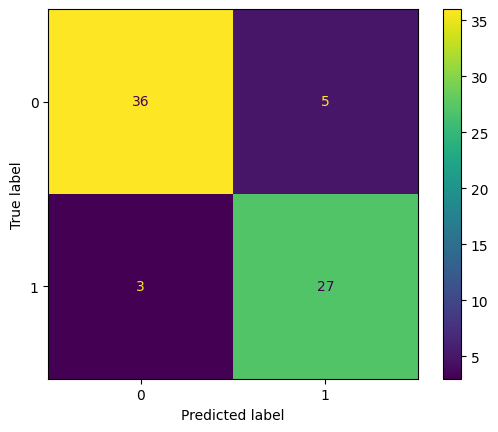

------------------------------------------------------------------------
confusion matrix & metrics fold: 2
Accuracy  0.9295774647887324
Recall  0.8666666666666667
Precision  0.9629629629629629
f1_score  0.912280701754386
Specificity  0.975609756097561
Tasa de error  0.07042253521126762


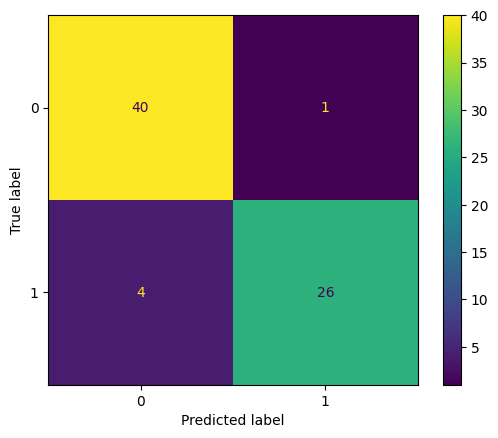

------------------------------------------------------------------------
confusion matrix & metrics fold: 3
Accuracy  0.9154929577464789
Recall  0.9428571428571428
Precision  0.8918918918918919
f1_score  0.9166666666666667
Specificity  0.8888888888888888
Tasa de error  0.08450704225352113


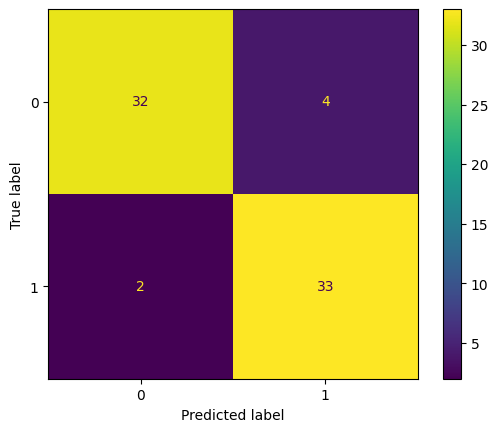

------------------------------------------------------------------------
confusion matrix & metrics fold: 4
Accuracy  0.9295774647887324
Recall  0.84
Precision  0.9545454545454546
f1_score  0.8936170212765958
Specificity  0.9782608695652174
Tasa de error  0.07042253521126762


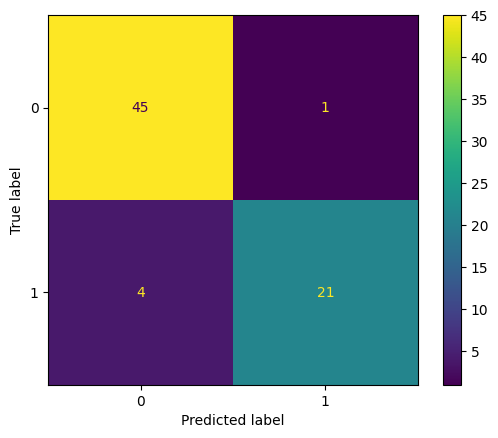

------------------------------------------------------------------------
confusion matrix & metrics fold: 5
Accuracy  0.971830985915493
Recall  0.972972972972973
Precision  0.972972972972973
f1_score  0.972972972972973
Specificity  0.9705882352941176
Tasa de error  0.028169014084507005


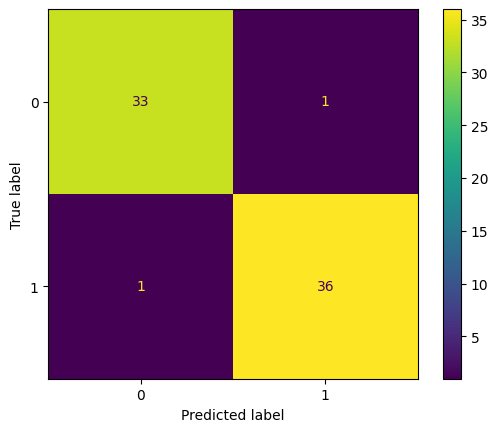

------------------------------------------------------------------------
confusion matrix & metrics fold: 6
Accuracy  0.9285714285714286
Recall  0.9032258064516129
Precision  0.9333333333333333
f1_score  0.9180327868852459
Specificity  0.9487179487179487
Tasa de error  0.0714285714285714


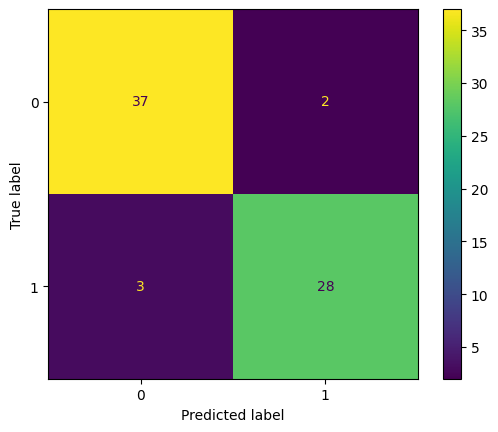

------------------------------------------------------------------------
confusion matrix & metrics fold: 7
Accuracy  0.8714285714285714
Recall  0.7666666666666667
Precision  0.92
f1_score  0.8363636363636363
Specificity  0.95
Tasa de error  0.12857142857142856


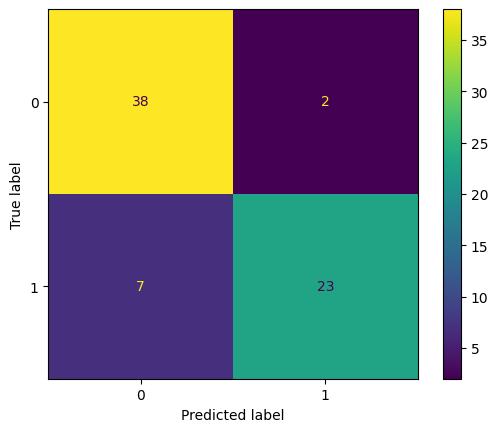

------------------------------------------------------------------------
confusion matrix & metrics fold: 8
Accuracy  0.9
Recall  0.8888888888888888
Precision  0.8571428571428571
f1_score  0.8727272727272727
Specificity  0.9069767441860465
Tasa de error  0.09999999999999998


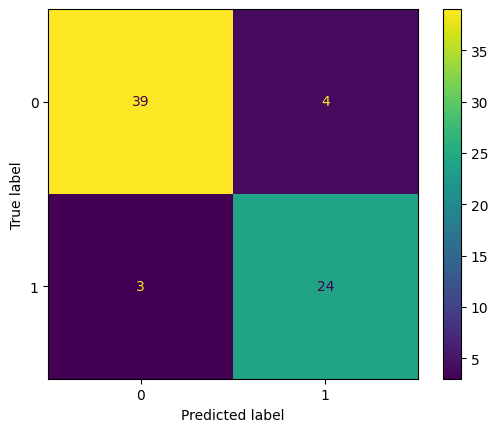

------------------------------------------------------------------------
confusion matrix & metrics fold: 9
Accuracy  0.9142857142857143
Recall  0.9354838709677419
Precision  0.8787878787878788
f1_score  0.90625
Specificity  0.8974358974358975
Tasa de error  0.08571428571428574


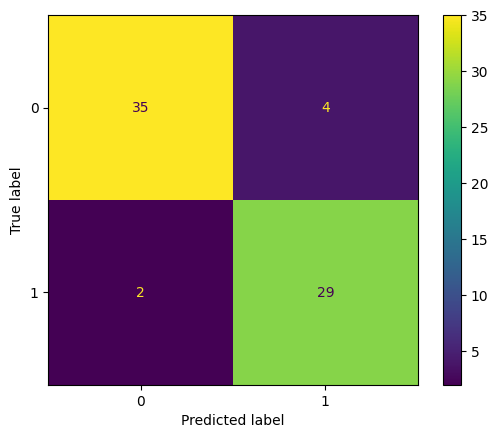

------------------------------------------------------------------------
confusion matrix & metrics fold: 10
Accuracy  0.9571428571428572
Recall  0.9310344827586207
Precision  0.9642857142857143
f1_score  0.9473684210526316
Specificity  0.975609756097561
Tasa de error  0.042857142857142816


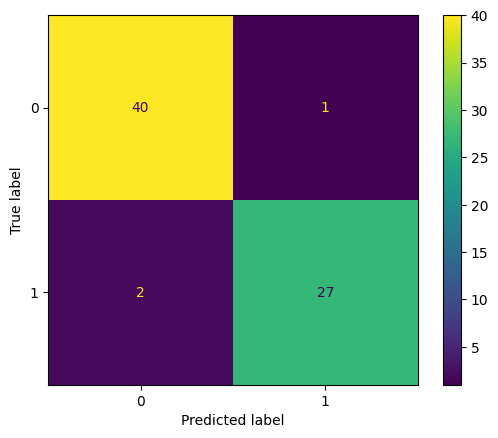

------------------------------------------------------------------------
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - val_loss: 0.3484945297241211 - val_accuracy: 88.73239159584045%
------------------------------------------------------------------------
> Fold 2 - val_loss: 0.3615878224372864 - val_accuracy: 92.95774698257446%
------------------------------------------------------------------------
> Fold 3 - val_loss: 0.38639718294143677 - val_accuracy: 91.54929518699646%
------------------------------------------------------------------------
> Fold 4 - val_loss: 0.2716507315635681 - val_accuracy: 92.95774698257446%
------------------------------------------------------------------------
> Fold 5 - val_loss: 0.3260607421398163 - val_accuracy: 97.183096408844%
------------------------------------------------------------------------
> Fold 6 - val_loss: 0.3798

In [37]:
#validacion cruzada y metricas
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
kfold = KFold(n_splits=10, shuffle=True, random_state=42) #k = 10 folds
fold_n = 1 #numero de fold

# Definir contenedores de score por fold
acc_per_fold = []
loss_per_fold = []

# Contenedores de matrices de confusion para cada fold
y_preds = []
y_trues = []

for train, valid in kfold.split(x_train_cv, y_train_cv):
    #crear modelo
    
    # crear la entrada para las imagenes
    input_layer = keras.layers.Input(shape=(128,128,3))
    x = base_models[0](input_layer)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    
    vgg19_model = keras.models.Model(inputs = input_layer, outputs = output, name=f"vgg19_model_fold_{fold_n}")

    vgg19_model.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['Accuracy'])

    #print("--"*120)
    print(f"Training for fold {fold_n} ...")

    # logs for tensorboard
    logs = './logs/vgg19/'
    tb = TensorBoard(log_dir=logs+vgg19_model.name)
    #Entrenar modelo
    vgg19_model.fit(x_train_cv[train], y_train_cv[train],
             validation_data=(x_train_cv[valid], y_train_cv[valid]),
             epochs = epochs, #100
             batch_size=batch_size, #32
             callbacks=[tb])
    
    #Puntuacion (val_loss y val_accuracy)
    scores = vgg19_model.evaluate(x_train_cv[valid], y_train_cv[valid], verbose=0)
    print(f"Score for fold {fold_n}: {vgg19_model.metrics_names[0]} of {scores[0]}; {vgg19_model.metrics_names[1]} of {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predicciones en set de validación
    print(f"Making predictions for fold {fold_n}...")
    y_pred_k = vgg19_model.predict(x_train_cv[valid])
    # Binarizar probabilidades umbral 0.5
    y_pred_k = np.where(y_pred_k >= 0.5, 1, 0)
    y_true_k = y_train_cv[valid]
    
    # almacenar predicciones y labels de cada fold
    y_trues.append(y_true_k)
    y_preds.append(y_pred_k)

    #aumentar contador fold
    fold_n += 1



avg_metrics_list = [] # lista para metricas promedio

# Matrices de confusion
print('-'*72)
print('Confusion matrix & Metrics per fold:')
print('-'*72)
for i in range(0, len(y_preds)):
    print(f'confusion matrix & metrics fold: {i+1}')
    metrics = plot_cm_metrics(y_trues[i], y_preds[i])
    avg_metrics_list.append(metrics)
    print('-'*72)

# == Provide average scores ==
print('-'*72)
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('-'*72)
  print(f'> Fold {i+1} - val_loss: {loss_per_fold[i]} - val_accuracy: {acc_per_fold[i]}%')
print('-'*72)
print('Average scores for all folds:')
print(f'> val_Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> val_Loss: {np.mean(loss_per_fold)}')
print('-'*72)

# == provide average metrics ==
print('Average Metrics for all folds:')

# Inicializar un diccionario para acumular los valores
suma_metricas = {key: 0 for key in avg_metrics_list[0]}

# Sumar los valores de cada métrica
for diccionario in avg_metrics_list:
    for clave, valor in diccionario.items():
        suma_metricas[clave] += valor

# Dividir entre el número de diccionarios para obtener el promedio
promedio_metricas = {clave: suma / len(avg_metrics_list) for clave, suma in suma_metricas.items()}

print("Promedio de métricas:")
for clave, valor in promedio_metricas.items():
    print(f"{clave}: {valor:.4f}")
print('-'*72)


In [40]:
!zip -r logs.zip logs/

  adding: logs/ (stored 0%)
  adding: logs/vgg19/ (stored 0%)
  adding: logs/vgg19/vgg19_model_fold_2/ (stored 0%)
  adding: logs/vgg19/vgg19_model_fold_2/validation/ (stored 0%)
  adding: logs/vgg19/vgg19_model_fold_2/validation/events.out.tfevents.1733192800.9adf10c70870.30.6.v2 (deflated 80%)
  adding: logs/vgg19/vgg19_model_fold_2/train/ (stored 0%)
  adding: logs/vgg19/vgg19_model_fold_2/train/events.out.tfevents.1733192788.9adf10c70870.30.5.v2 (deflated 89%)
  adding: logs/vgg19/vgg19_model_fold_3/ (stored 0%)
  adding: logs/vgg19/vgg19_model_fold_3/validation/ (stored 0%)
  adding: logs/vgg19/vgg19_model_fold_3/validation/events.out.tfevents.1733192955.9adf10c70870.30.8.v2 (deflated 80%)
  adding: logs/vgg19/vgg19_model_fold_3/train/ (stored 0%)
  adding: logs/vgg19/vgg19_model_fold_3/train/events.out.tfevents.1733192943.9adf10c70870.30.7.v2 (deflated 89%)
  adding: logs/vgg19/vgg19_model_fold_1/ (stored 0%)
  adding: logs/vgg19/vgg19_model_fold_1/validation/ (stored 0%)
  addin

### resnet50

### Aplicar preprocessing input for resnet50

```python
from keras.applications.resnet50 import preprocess_input
```

In [14]:
from keras.applications.resnet50 import preprocess_input

x_train_cv_resnet = preprocess_input(x_train_cv)

Training for fold 1 ...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 573ms/step - Accuracy: 0.4716 - loss: 3.8904 - val_Accuracy: 0.5775 - val_loss: 1.0351
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - Accuracy: 0.5830 - loss: 2.2625 - val_Accuracy: 0.7746 - val_loss: 0.4685
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - Accuracy: 0.6638 - loss: 1.2587 - val_Accuracy: 0.8451 - val_loss: 0.3584
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - Accuracy: 0.6630 - loss: 1.0591 - val_Accuracy: 0.8592 - val_loss: 0.3532
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - Accuracy: 0.8098 - loss: 0.5271 - val_Accuracy: 0.8310 - val_loss: 0.3501
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - Accuracy: 0.7762 - loss: 0.6332 - val_Accuracy: 0.8592 - val_loss: 0.3207
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - Accuracy: 0.8097 - loss: 0.4622 - val_Accuracy: 0.9155 - val_loss: 0.2285
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - Accuracy: 0.8443 - loss:

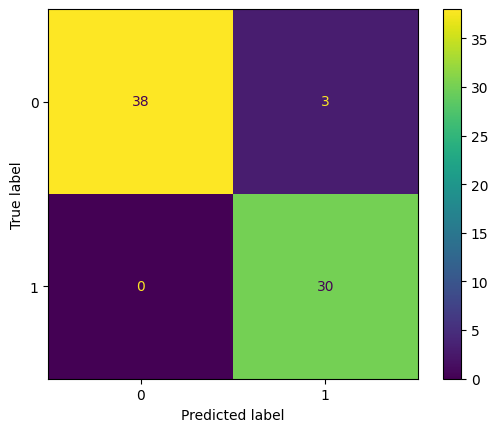

------------------------------------------------------------------------
confusion matrix & metrics fold: 2
Accuracy  0.9154929577464789
Recall  0.9
Precision  0.9
f1_score  0.9
Specificity  0.926829268292683
Tasa de error  0.08450704225352113


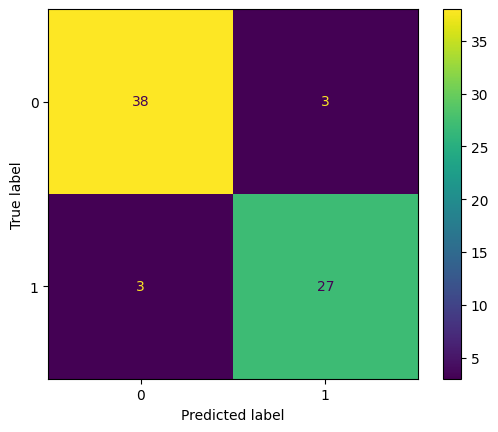

------------------------------------------------------------------------
confusion matrix & metrics fold: 3
Accuracy  0.9154929577464789
Recall  0.9428571428571428
Precision  0.8918918918918919
f1_score  0.9166666666666667
Specificity  0.8888888888888888
Tasa de error  0.08450704225352113


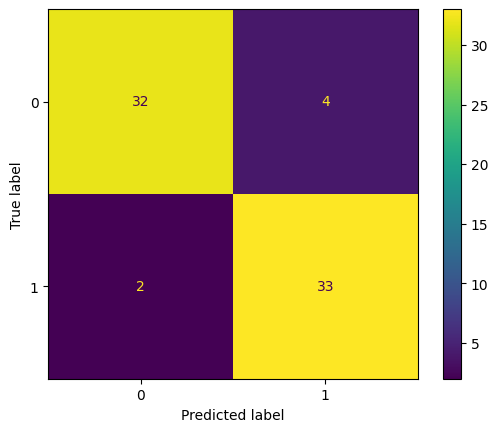

------------------------------------------------------------------------
confusion matrix & metrics fold: 4
Accuracy  0.9436619718309859
Recall  0.92
Precision  0.92
f1_score  0.92
Specificity  0.9565217391304348
Tasa de error  0.05633802816901412


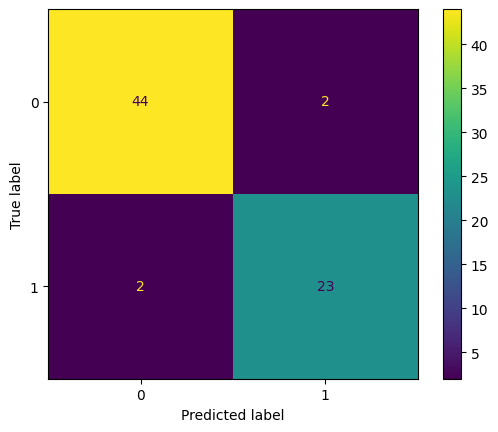

------------------------------------------------------------------------
confusion matrix & metrics fold: 5
Accuracy  0.9859154929577465
Recall  1.0
Precision  0.9736842105263158
f1_score  0.9866666666666666
Specificity  0.9705882352941176
Tasa de error  0.014084507042253502


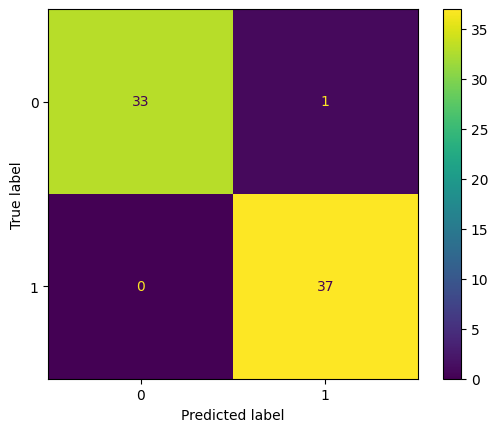

------------------------------------------------------------------------
confusion matrix & metrics fold: 6
Accuracy  0.9
Recall  0.8387096774193549
Precision  0.9285714285714286
f1_score  0.8813559322033899
Specificity  0.9487179487179487
Tasa de error  0.09999999999999998


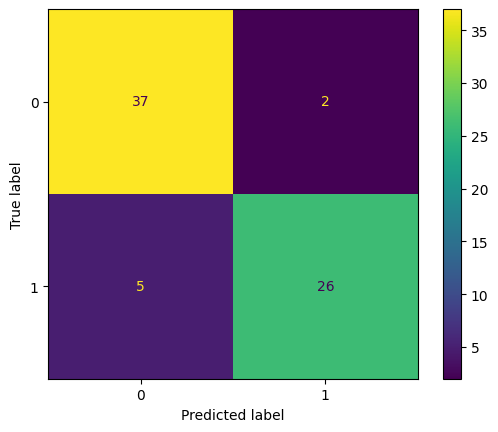

------------------------------------------------------------------------
confusion matrix & metrics fold: 7
Accuracy  0.9428571428571428
Recall  0.9
Precision  0.9642857142857143
f1_score  0.9310344827586207
Specificity  0.975
Tasa de error  0.05714285714285716


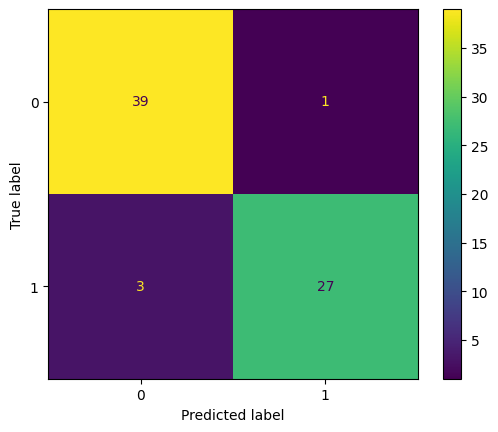

------------------------------------------------------------------------
confusion matrix & metrics fold: 8
Accuracy  0.9571428571428572
Recall  1.0
Precision  0.9
f1_score  0.9473684210526316
Specificity  0.9302325581395349
Tasa de error  0.042857142857142816


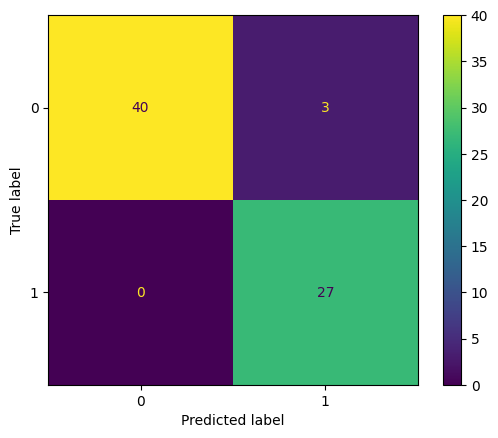

------------------------------------------------------------------------
confusion matrix & metrics fold: 9
Accuracy  0.8857142857142857
Recall  0.9032258064516129
Precision  0.8484848484848485
f1_score  0.875
Specificity  0.8717948717948718
Tasa de error  0.11428571428571432


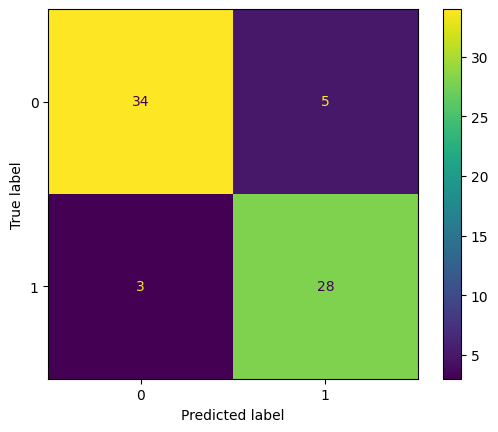

------------------------------------------------------------------------
confusion matrix & metrics fold: 10
Accuracy  1.0
Recall  1.0
Precision  1.0
f1_score  1.0
Specificity  1.0
Tasa de error  0.0


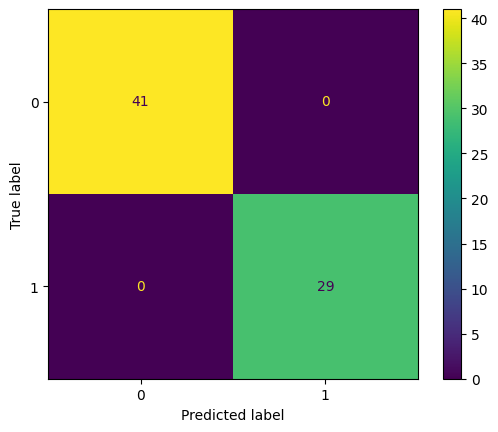

------------------------------------------------------------------------
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - val_loss: 0.32459190487861633 - val_accuracy: 95.77465057373047%
------------------------------------------------------------------------
> Fold 2 - val_loss: 1.353261113166809 - val_accuracy: 91.54929518699646%
------------------------------------------------------------------------
> Fold 3 - val_loss: 0.2978193461894989 - val_accuracy: 91.54929518699646%
------------------------------------------------------------------------
> Fold 4 - val_loss: 0.6454460620880127 - val_accuracy: 94.36619877815247%
------------------------------------------------------------------------
> Fold 5 - val_loss: 0.048715539276599884 - val_accuracy: 98.591548204422%
------------------------------------------------------------------------
> Fold 6 - val_loss: 0.863

In [15]:
#validacion cruzada y metricas
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
kfold = KFold(n_splits=10, shuffle=True, random_state=42) #k = 10 folds
fold_n = 1 #numero de fold

# Definir contenedores de score por fold
acc_per_fold = []
loss_per_fold = []

# Contenedores de matrices de confusion para cada fold
y_preds = []
y_trues = []

for train, valid in kfold.split(x_train_cv_resnet, y_train_cv):
    #crear modelo
    
    # crear la entrada para las imagenes
    input_layer = keras.layers.Input(shape=(128,128,3))
    x = base_models[1](input_layer)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    
    resnet50_model = keras.models.Model(inputs = input_layer, outputs = output, name=f"resnet50_model_fold_{fold_n}")

    resnet50_model.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['Accuracy'])

    #print("--"*120)
    print(f"Training for fold {fold_n} ...")

    # logs for tensorboard
    logs = './logs/resnet50/'
    tb = TensorBoard(log_dir=logs+resnet50_model.name)
    #Entrenar modelo
    resnet50_model.fit(x_train_cv_resnet[train], y_train_cv[train],
             validation_data=(x_train_cv_resnet[valid], y_train_cv[valid]),
             epochs = epochs, #100
             batch_size=batch_size, #32
             callbacks=[tb])
    
    #Puntuacion (val_loss y val_accuracy)
    scores = resnet50_model.evaluate(x_train_cv_resnet[valid], y_train_cv[valid], verbose=0)
    print(f"Score for fold {fold_n}: {resnet50_model.metrics_names[0]} of {scores[0]}; {resnet50_model.metrics_names[1]} of {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predicciones en set de validación
    print(f"Making predictions for fold {fold_n}...")
    y_pred_k = resnet50_model.predict(x_train_cv_resnet[valid])
    # Binarizar probabilidades umbral 0.5
    y_pred_k = np.where(y_pred_k >= 0.5, 1, 0)
    y_true_k = y_train_cv[valid]
    
    # almacenar predicciones y labels de cada fold
    y_trues.append(y_true_k)
    y_preds.append(y_pred_k)

    #aumentar contador fold
    fold_n += 1



avg_metrics_list = [] # lista para metricas promedio

# Matrices de confusion
print('-'*72)
print('Confusion matrix & Metrics per fold:')
print('-'*72)
for i in range(0, len(y_preds)):
    print(f'confusion matrix & metrics fold: {i+1}')
    metrics = plot_cm_metrics(y_trues[i], y_preds[i])
    avg_metrics_list.append(metrics)
    print('-'*72)

# == Provide average scores ==
print('-'*72)
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('-'*72)
  print(f'> Fold {i+1} - val_loss: {loss_per_fold[i]} - val_accuracy: {acc_per_fold[i]}%')
print('-'*72)
print('Average scores for all folds:')
print(f'> val_Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> val_Loss: {np.mean(loss_per_fold)}')
print('-'*72)

# == provide average metrics ==
print('Average Metrics for all folds:')

# Inicializar un diccionario para acumular los valores
suma_metricas = {key: 0 for key in avg_metrics_list[0]}

# Sumar los valores de cada métrica
for diccionario in avg_metrics_list:
    for clave, valor in diccionario.items():
        suma_metricas[clave] += valor

# Dividir entre el número de diccionarios para obtener el promedio
promedio_metricas = {clave: suma / len(avg_metrics_list) for clave, suma in suma_metricas.items()}

print("Promedio de métricas:")
for clave, valor in promedio_metricas.items():
    print(f"{clave}: {valor:.4f}")
print('-'*72)


### Densenet121

Training for fold 1 ...
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - Accuracy: 0.5065 - loss: 2.9307 - val_Accuracy: 0.7324 - val_loss: 0.4953
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - Accuracy: 0.6493 - loss: 1.4369 - val_Accuracy: 0.7606 - val_loss: 0.4563
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - Accuracy: 0.6982 - loss: 1.0874 - val_Accuracy: 0.7746 - val_loss: 0.4252
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - Accuracy: 0.7421 - loss: 0.7561 - val_Accuracy: 0.8310 - val_loss: 0.3919
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - Accuracy: 0.7824 - loss: 0.5977 - val_Accuracy: 0.9014 - val_loss: 0.3389
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - Accuracy: 0.8233 - loss: 0.4612 - val_Accuracy: 0.8873 - val_loss: 0.3147
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - Accuracy: 0.8683 - loss: 0.3330 - val_Accuracy: 0.9296 - val_loss: 0.3142
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - Accuracy: 0.8837 - loss: 0.

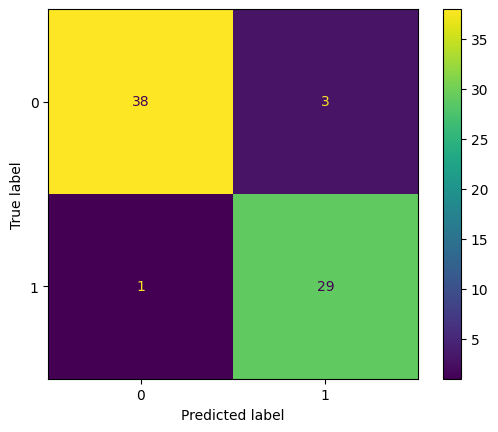

------------------------------------------------------------------------
confusion matrix & metrics fold: 2
Accuracy  0.9154929577464789
Recall  0.9
Precision  0.9
f1_score  0.9
Specificity  0.926829268292683
Tasa de error  0.08450704225352113


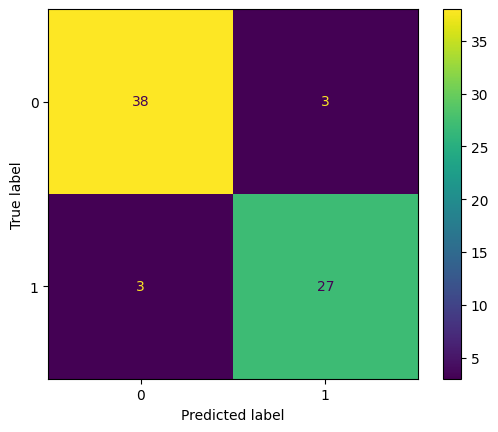

------------------------------------------------------------------------
confusion matrix & metrics fold: 3
Accuracy  0.9154929577464789
Recall  0.8285714285714286
Precision  1.0
f1_score  0.90625
Specificity  1.0
Tasa de error  0.08450704225352113


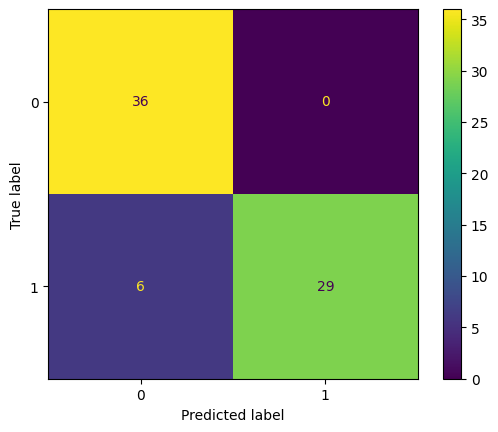

------------------------------------------------------------------------
confusion matrix & metrics fold: 4
Accuracy  0.9577464788732394
Recall  1.0
Precision  0.8928571428571429
f1_score  0.9433962264150945
Specificity  0.9347826086956522
Tasa de error  0.04225352112676062


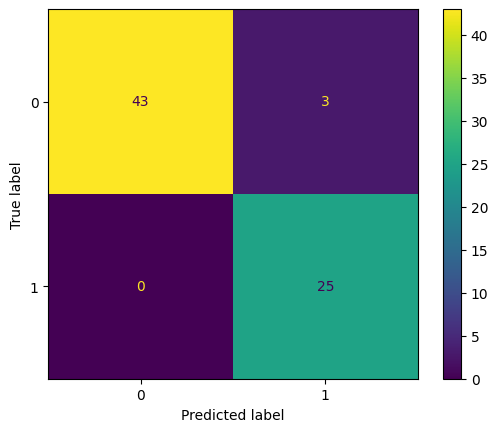

------------------------------------------------------------------------
confusion matrix & metrics fold: 5
Accuracy  0.9436619718309859
Recall  0.9459459459459459
Precision  0.9459459459459459
f1_score  0.9459459459459459
Specificity  0.9411764705882353
Tasa de error  0.05633802816901412


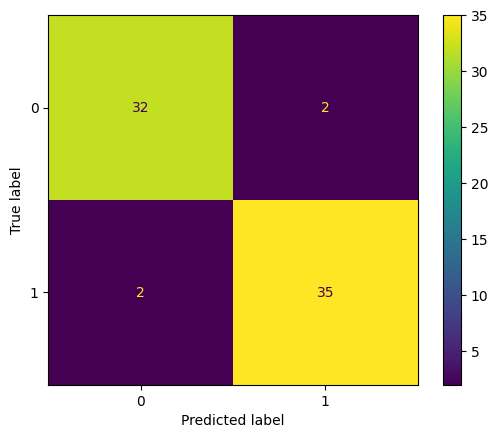

------------------------------------------------------------------------
confusion matrix & metrics fold: 6
Accuracy  0.8857142857142857
Recall  0.8064516129032258
Precision  0.9259259259259259
f1_score  0.8620689655172414
Specificity  0.9487179487179487
Tasa de error  0.11428571428571432


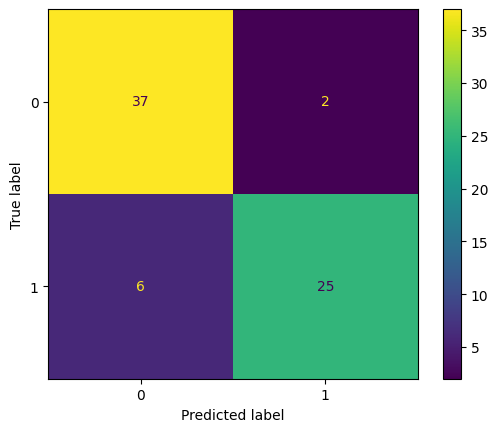

------------------------------------------------------------------------
confusion matrix & metrics fold: 7
Accuracy  0.9428571428571428
Recall  0.9
Precision  0.9642857142857143
f1_score  0.9310344827586207
Specificity  0.975
Tasa de error  0.05714285714285716


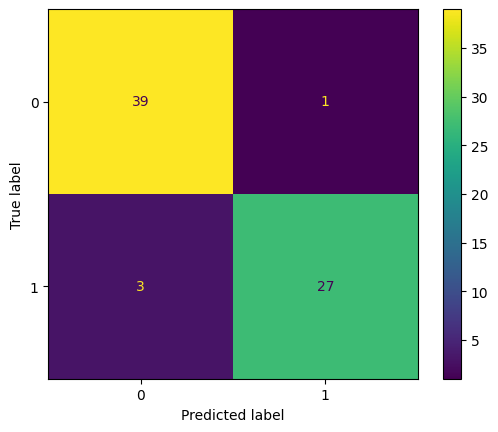

------------------------------------------------------------------------
confusion matrix & metrics fold: 8
Accuracy  0.9285714285714286
Recall  0.9259259259259259
Precision  0.8928571428571429
f1_score  0.9090909090909091
Specificity  0.9302325581395349
Tasa de error  0.0714285714285714


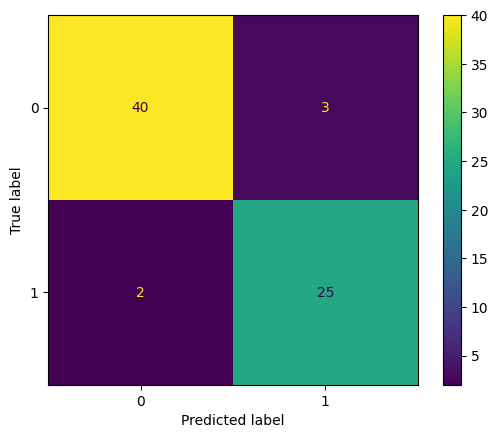

------------------------------------------------------------------------
confusion matrix & metrics fold: 9
Accuracy  0.9428571428571428
Recall  0.8709677419354839
Precision  1.0
f1_score  0.9310344827586207
Specificity  1.0
Tasa de error  0.05714285714285716


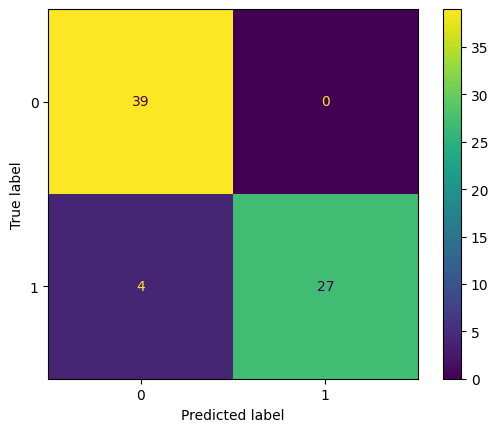

------------------------------------------------------------------------
confusion matrix & metrics fold: 10
Accuracy  0.9857142857142858
Recall  0.9655172413793104
Precision  1.0
f1_score  0.9824561403508771
Specificity  1.0
Tasa de error  0.014285714285714235


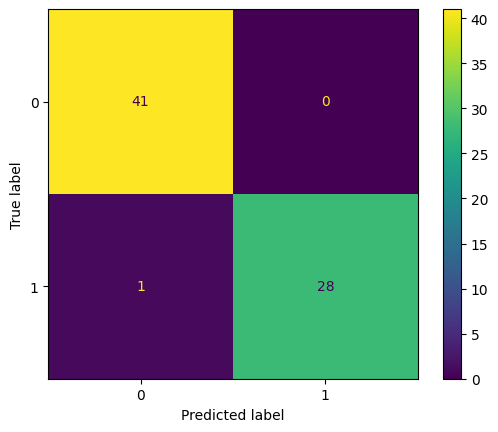

------------------------------------------------------------------------
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - val_loss: 0.5859907269477844 - val_accuracy: 94.36619877815247%
------------------------------------------------------------------------
> Fold 2 - val_loss: 0.40350341796875 - val_accuracy: 91.54929518699646%
------------------------------------------------------------------------
> Fold 3 - val_loss: 0.49787914752960205 - val_accuracy: 91.54929518699646%
------------------------------------------------------------------------
> Fold 4 - val_loss: 0.06970056891441345 - val_accuracy: 95.77465057373047%
------------------------------------------------------------------------
> Fold 5 - val_loss: 0.1387757658958435 - val_accuracy: 94.36619877815247%
------------------------------------------------------------------------
> Fold 6 - val_loss: 0.531

In [8]:
#validacion cruzada y metricas
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
kfold = KFold(n_splits=10, shuffle=True, random_state=42) #k = 10 folds
fold_n = 1 #numero de fold

# Definir contenedores de score por fold
acc_per_fold = []
loss_per_fold = []

# Contenedores de matrices de confusion para cada fold
y_preds = []
y_trues = []

for train, valid in kfold.split(x_train_cv, y_train_cv):
    #crear modelo
    
    # crear la entrada para las imagenes
    input_layer = keras.layers.Input(shape=(128,128,3))
    x = base_models[2](input_layer)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation='sigmoid')(x)
    
    densenet121_model = keras.models.Model(inputs = input_layer, outputs = output, name=f"densenet121_model_fold_{fold_n}")

    densenet121_model.compile(loss='binary_crossentropy',
                    optimizer=keras.optimizers.Adam(),
                    metrics=['Accuracy'])

    #print("--"*120)
    print(f"Training for fold {fold_n} ...")

    # logs for tensorboard
    logs = './logs/densenet121/'
    tb = TensorBoard(log_dir=logs+densenet121_model.name)
    #Entrenar modelo
    densenet121_model.fit(x_train_cv[train], y_train_cv[train],
             validation_data=(x_train_cv[valid], y_train_cv[valid]),
             epochs = epochs, #100
             batch_size=batch_size, #32
             callbacks=[tb])
    
    #Puntuacion (val_loss y val_accuracy)
    scores = densenet121_model.evaluate(x_train_cv[valid], y_train_cv[valid], verbose=0)
    print(f"Score for fold {fold_n}: {densenet121_model.metrics_names[0]} of {scores[0]}; {densenet121_model.metrics_names[1]} of {scores[1]*100}%")
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Predicciones en set de validación
    print(f"Making predictions for fold {fold_n}...")
    y_pred_k = densenet121_model.predict(x_train_cv[valid])
    # Binarizar probabilidades umbral 0.5
    y_pred_k = np.where(y_pred_k >= 0.5, 1, 0)
    y_true_k = y_train_cv[valid]
    
    # almacenar predicciones y labels de cada fold
    y_trues.append(y_true_k)
    y_preds.append(y_pred_k)

    #aumentar contador fold
    fold_n += 1



avg_metrics_list = [] # lista para metricas promedio

# Matrices de confusion
print('-'*72)
print('Confusion matrix & Metrics per fold:')
print('-'*72)
for i in range(0, len(y_preds)):
    print(f'confusion matrix & metrics fold: {i+1}')
    metrics = plot_cm_metrics(y_trues[i], y_preds[i])
    avg_metrics_list.append(metrics)
    print('-'*72)

# == Provide average scores ==
print('-'*72)
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('-'*72)
  print(f'> Fold {i+1} - val_loss: {loss_per_fold[i]} - val_accuracy: {acc_per_fold[i]}%')
print('-'*72)
print('Average scores for all folds:')
print(f'> val_Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> val_Loss: {np.mean(loss_per_fold)}')
print('-'*72)

# == provide average metrics ==
print('Average Metrics for all folds:')

# Inicializar un diccionario para acumular los valores
suma_metricas = {key: 0 for key in avg_metrics_list[0]}

# Sumar los valores de cada métrica
for diccionario in avg_metrics_list:
    for clave, valor in diccionario.items():
        suma_metricas[clave] += valor

# Dividir entre el número de diccionarios para obtener el promedio
promedio_metricas = {clave: suma / len(avg_metrics_list) for clave, suma in suma_metricas.items()}

print("Promedio de métricas:")
for clave, valor in promedio_metricas.items():
    print(f"{clave}: {valor:.4f}")
print('-'*72)


In [9]:
!zip -r logs.zip logs/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: logs/ (stored 0%)
  adding: logs/resnet50/ (stored 0%)
  adding: logs/resnet50/resnet50_model_fold_7/ (stored 0%)
  adding: logs/resnet50/resnet50_model_fold_7/validation/ (stored 0%)
  adding: logs/resnet50/resnet50_model_fold_7/validation/events.out.tfevents.1733266910.3dfff3860cce.30.13.v2 (deflated 81%)
  adding: logs/resnet50/resnet50_model_fold_7/train/ (stored 0%)
  adding: logs/resnet50/resnet50_model_fold_7/train/events.out.tfevents.1733266890.3dfff3860cce.30.12.v2 (deflated 94%)
  adding: logs/resnet50/resnet50_model_fold_6/ (stored 0%)
  adding: logs/resnet50/resnet50_model_fold_6/validation/ (stored 0%)
  adding: logs/resnet50/resnet50_model_fold_6/validation/events.out.tfevents.1733266794.3dfff3860cce.30.11.v2 (deflated 81%)
  adding: logs/resnet50/resnet50_model_fold_6/train/ (stored 0%)
  adding: logs/resnet50/resnet50_model_fold_6/train/events.out.tfevents.1733266772.3dfff3860cce.30.10.v2 (deflated 94%)
  adding: logs/resnet50/resnet50_model_fold_2/ (stored 0%

## Tabla resumen modelos base

<table>
    <tr>
    <td>Modelos</td>
    <td>Val_accuracy</td>
    <td>Val_loss</td>
    <td>Accuracy</td>
    <td>Recall</td>
    <td>Precision</td>
    <td>f1_score</td>
    <td>Specificity</td>
    <td>Tasa de error</td>
  </tr>
    <tr>
    <td>VGG19</td>
    <td>95.0523% ${\pm}$ 2.8636</td>
    <td>0.3073</td>
    <td>0.9205</td>
    <td>0.8948</td>
    <td>0.9180</td>
    <td>0.9047</td>
    <td>0.9370</td>
    <td>0.0795</td>
  </tr>
    <tr>
    <td>RestNet-50</td>
    <td>94.0402% ${\pm}$ 3.4763</td>
    <td>0.5072</td>
    <td>0.9404</td>
    <td>0.9405</td>
    <td>0.9236</td>
    <td>0.9310</td>
    <td>0.9395</td>
    <td>0.0596</td>
  </tr>
    <tr>
    <td>DenseNet121</td>
    <td>93.6177% ${\pm}$ 2.5652</td>
    <td>0.3403</td>
    <td>0.9362</td>
    <td>0.9110</td>
    <td>0.9428</td>
    <td>0.9247</td>
    <td>0.9584</td>
    <td>0.0638</td>
  </tr>
</table>

## Tabla de resultados General

<table>
  <tr>
    <td>Modelos</td>
    <td>Val_accuracy</td>
    <td>Val_loss</td>
    <td>Accuracy</td>
    <td>Recall</td>
    <td>Precision</td>
    <td>f1_score</td>
    <td>Specificity</td>
    <td>Tasa de error</td>
  </tr>
  <tr>
    <td>MoE 1 experto</td>
    <td>82.8410% ${\pm}$ 14.3704%</td>
    <td>0.4898</td>
    <td>0.8284</td>
    <td>0.6900</td>
    <td>0.7902</td>
    <td>0.7161</td>
    <td>0.9367</td>
    <td>0.1716</td>
  </tr>
  <tr>
    <td>MoE 2 expertos</td>
    <td>88.5090% ${\pm}$ 4.3651%</td>
    <td>0.3525</td>
    <td>0.8851</td>
    <td>0.8644</td>
    <td>0.8934</td>
    <td>0.8644</td>
    <td>0.9161</td>
    <td>0.1149</td>
  </tr>
  <tr>
    <td>MoE 3 expertos</td>
    <td>94.1770% ${\pm}$ 1.8709%</td>
    <td>0.4677</td>
    <td>0.9418</td>
    <td>0.9272</td>
    <td>0.9367</td>
    <td>0.9309</td>
    <td>0.9532</td>
    <td>0.0582</td>
  </tr>
    <tr>
    <td>VGG19</td>
    <td>95.0523% ${\pm}$ 2.8636</td>
    <td>0.3073</td>
    <td>0.9205</td>
    <td>0.8948</td>
    <td>0.9180</td>
    <td>0.9047</td>
    <td>0.9370</td>
    <td>0.0795</td>
  </tr>
    <tr>
    <td>RestNet-50</td>
    <td>94.0402% ${\pm}$ 3.4763</td>
    <td>0.5072</td>
    <td>0.9404</td>
    <td>0.9405</td>
    <td>0.9236</td>
    <td>0.9310</td>
    <td>0.9395</td>
    <td>0.0596</td>
  </tr>
    <tr>
    <td>DenseNet121</td>
    <td>93.6177% ${\pm}$ 2.5652</td>
    <td>0.3403</td>
    <td>0.9362</td>
    <td>0.9110</td>
    <td>0.9428</td>
    <td>0.9247</td>
    <td>0.9584</td>
    <td>0.0638</td>
  </tr>
</table>


## Resultados.

### Val_accuracy (Precisión de validación):

Esta métrica mide la precisión de los modelos en el conjunto de validación.
Podemos ver que los modelos de Mezcla de Expertos (MoE) generalmente superan a las arquitecturas CNN estándar, siendo el modelo MoE de 3 expertos el que logra la mayor precisión de validación con 94.17%.
Esto sugiere que el enfoque de Mezcla de Expertos es efectivo para aprender un modelo más preciso en comparación con las redes convolucionales individuales.

### Val_loss (Pérdida de validación):

Esta es la pérdida de validación, que mide qué tan bien el modelo minimiza la función de pérdida en los datos de validación.
Una vez más, los modelos MoE muestran valores de pérdida de validación más bajos que las CNN independientes, siendo el MoE de 3 expertos el que tiene la pérdida más baja con 0.4677.
La menor pérdida de validación indica que los modelos MoE tienen una mejor capacidad de generalización y evitan el sobreajuste en comparación con las arquitecturas CNN más sencillas.

### Accuracy, Recall, Precision, F1-score (Precisión, Exhaustividad, Precisión, Puntaje F1):

Estas son métricas de clasificación estándar que evalúan diferentes aspectos del desempeño predictivo del modelo.
En general, los modelos MoE superan a las CNN independientes en estas métricas también, siendo el modelo MoE de 3 expertos el que tiene el mejor desempeño.
Esto confirma aún más que el enfoque de Mezcla de Expertos conduce a una mayor capacidad predictiva general en comparación con los modelos CNN individuales.

### Specificity (Especificidad):

Esta métrica analiza la capacidad del modelo para identificar correctamente las instancias de la clase negativa.
Los modelos MoE nuevamente muestran valores de especificidad más altos que las CNN, lo que indica que pueden distinguir mejor entre predicciones positivas y negativas.

### Tasa de error:

Esta es la tasa de error, donde valores más bajos son mejores.
Consistente con las otras métricas, los modelos MoE tienen tasas de error más bajas que las CNN independientes.



En resumen, los modelos de Mezcla de Expertos, especialmente la versión de 3 expertos, demuestran un desempeño superior en una variedad de métricas de evaluación en comparación con las arquitecturas CNN estándar. Esto sugiere que el enfoque de Mezcla de Expertos es una manera efectiva de mejorar el poder predictivo de los modelos subyacentes al aprovechar los puntos fuertes complementarios de múltiples expertos. La mayor precisión, la menor pérdida y otras métricas mejoradas indican que los modelos MoE pueden aprender una representación más robusta y generalizable de los datos.